##### Горохов Владислав, ПМИ 433

## Кейс по эконометрике

# Тема: "Моделирование и прогнозирование курса Биткоина"

In [ ]:
load('./case_BTC.RData')

## Загрузка данных

Загрузим данные и выведем первые 10 строк полученного набора:

In [2]:
BTC <- read.csv('./data/CBBTCUSD.csv')
BTC['CBBTCUSD'] <- sapply(BTC['CBBTCUSD'], as.numeric)
BTC$DATE <- as.Date(BTC$DATE, format='%Y-%m-%d')

print(head(bitcoinUSD, 10), row.names=FALSE)

Warning message in lapply(X = X, FUN = FUN, ...):
"в результате преобразования созданы NA"


  t       DATE CBBTCUSD
  1 2017-02-15  1014.53
  2 2017-02-16  1038.94
  3 2017-02-17  1057.30
  4 2017-02-18  1062.15
  5 2017-02-19  1059.88
  6 2017-02-20  1089.82
  7 2017-02-21  1128.29
  8 2017-02-22  1128.71
  9 2017-02-23  1186.90
 10 2017-02-24  1186.91


Имеем подневные данные без пропусков, обсуловленных выходными или праздничными днями.

## Предварительная обработка подневных данных временного ряда

Проверим наличие в данных пропущенных по ошибке значений:

In [3]:
sum(is.na(BTC['CBBTCUSD']))

[1] 1

Имеем один пропуск.  
Заполним его предыдущим значением:

In [4]:
library(tidyverse)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [5]:
BTC <- BTC %>%
    mutate(CBBTCUSD = ifelse(is.na(CBBTCUSD), CBBTCUSD[which(is.na(CBBTCUSD)) - 1], CBBTCUSD))

Получим основные описательные статистики исследуемого ряда:

In [6]:
library(skimr)
library(psych)


Присоединяю пакет: 'psych'


Следующие объекты скрыты от 'package:ggplot2':

    %+%, alpha




In [7]:
print(describe(BTC$CBBTCUSD))

   vars    n     mean       sd  median  trimmed     mad    min      max
X1    1 1827 16497.32 17311.02 8892.39 13432.95 5534.37 934.87 67510.06
      range skew kurtosis  se
X1 66575.19  1.4     0.52 405


Распределение ряда имеет правостороннюю асимметрию, поскольку коэффициент асимметрии равен 1,4, а избыточный эксцесс распределения, равный 0,52, лежит в допустимых пределах [-1; 1] отклонения от нормального распределения.

In [8]:
fix_windows_histograms()  # опция для корректного отображения гистограмм
skim(BTC$CBBTCUSD)
Sys.setlocale("LC_CTYPE", "russian")

This function will change your system locale. It may have other unintended effects.



Continue? (Y/n) Y


,skim_type,skim_variable,n_missing,complete_rate,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,numeric,CBBTCUSD,0,1,16497.32,17311.02,934.87,6191.51,8892.39,17734.39,67510.06,▇▁▁▁▁


-- Data Summary ------------------------
                           Values      
Name                       BTC$CBBTCUSD
Number of rows             1827        
Number of columns          1           
_______________________                
Column type frequency:                 
  numeric                  1           
________________________               
Group variables            None        

-- Variable type: numeric ------------------------------------------------------
  skim_variable n_missing complete_rate   mean     sd   p0   p25   p50    p75
1 CBBTCUSD              0             1 16497. 17311. 935. 6192. 8892. 17734.
    p100 hist 
1 67510. ▇▁▁▁▁


[1] "Russian_Russia.1251"

Как видим, имеем ряд из T = 1827 наблюдений. Пропуски в данных после их заполнения отсутствуют.

Построим график функции плотности распределения ряда:

In [9]:
library(ggplot2)
library(ggfortify)

In [10]:
# функция для задания размера графиков
fig <- function(width, heigth, dpi=110) {
  options(repr.plot.width = width, repr.plot.height = heigth, repr.plot.res=dpi)
}

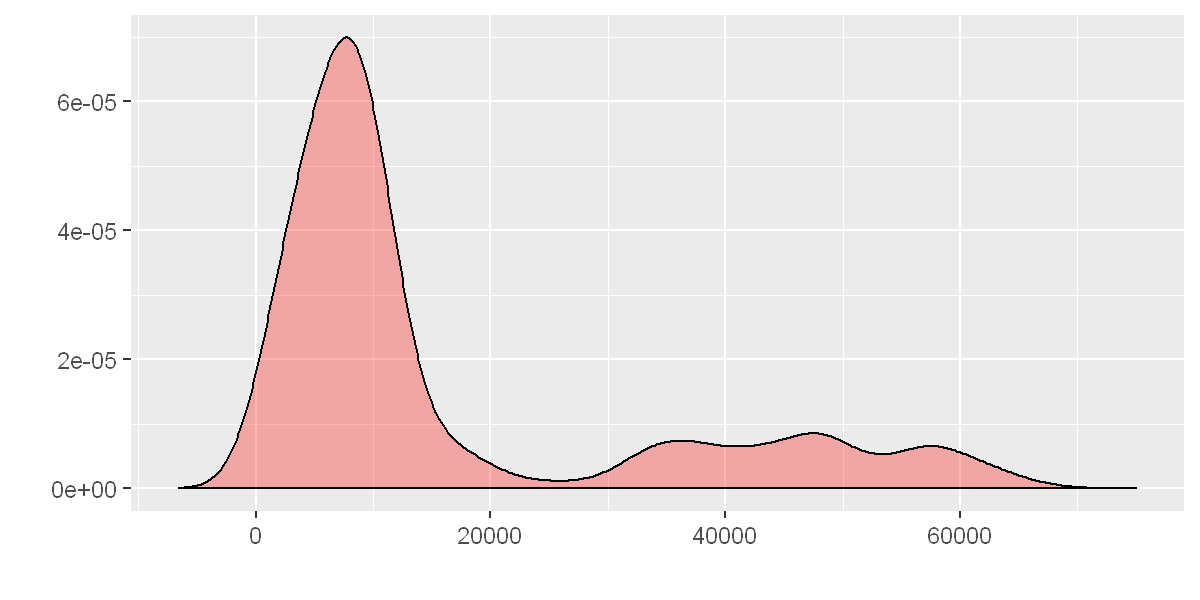

In [11]:
fig(6, 3, 200)
autoplot(density(BTC$CBBTCUSD, adjust=1.45), fill='red')

Как видим, распределение исходного ряда дневных данных является мультимодальным.

Для моделирования подневных данных будем использовать последние 400 наблюдений всего ряда:

In [12]:
BTC_daily <- BTC[1428:1827, ]

Для урезанных данных проверим основные статистические характеристики:

In [13]:
print(describe(BTC_daily$CBBTCUSD))

   vars   n     mean      sd   median  trimmed      mad      min      max
X1    1 400 47064.99 9404.45 47077.87 46927.09 12847.49 29788.61 67510.06
      range skew kurtosis     se
X1 37721.45 0.09    -1.07 470.22


Видим, что распределение имеет небольшую левостороннюю асимметрию и избыточный отрицательный эксцесс, который немного выходит за пределы допустимых отклонений [-1; 1].  
Построим график распределения урезанных подневных данных:

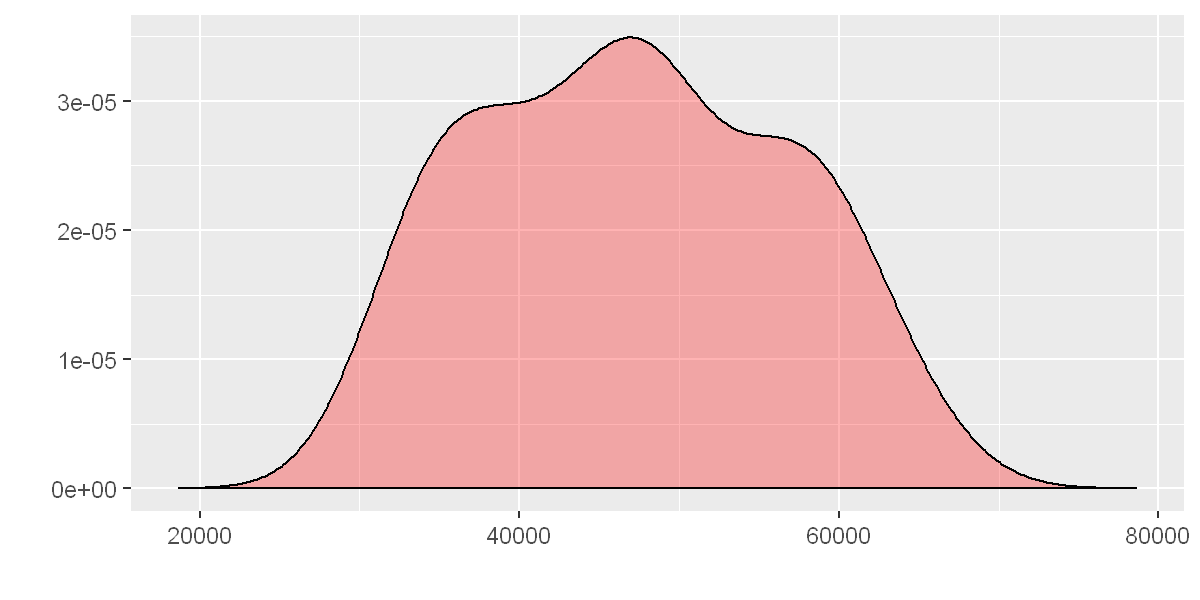

In [14]:
fig(6, 3, 200)
autoplot(density(BTC_daily$CBBTCUSD, adjust=1.45), fill='red')

Видим также, что распределение мультимодально.

Поскольку данные не распределены нормально, то для тестирования наличия грубых ошибок в данных не можем применять робастные статистические методы. Проверим данные на наличие выдающихся значений (выбросов), построив диаграмму размаха:

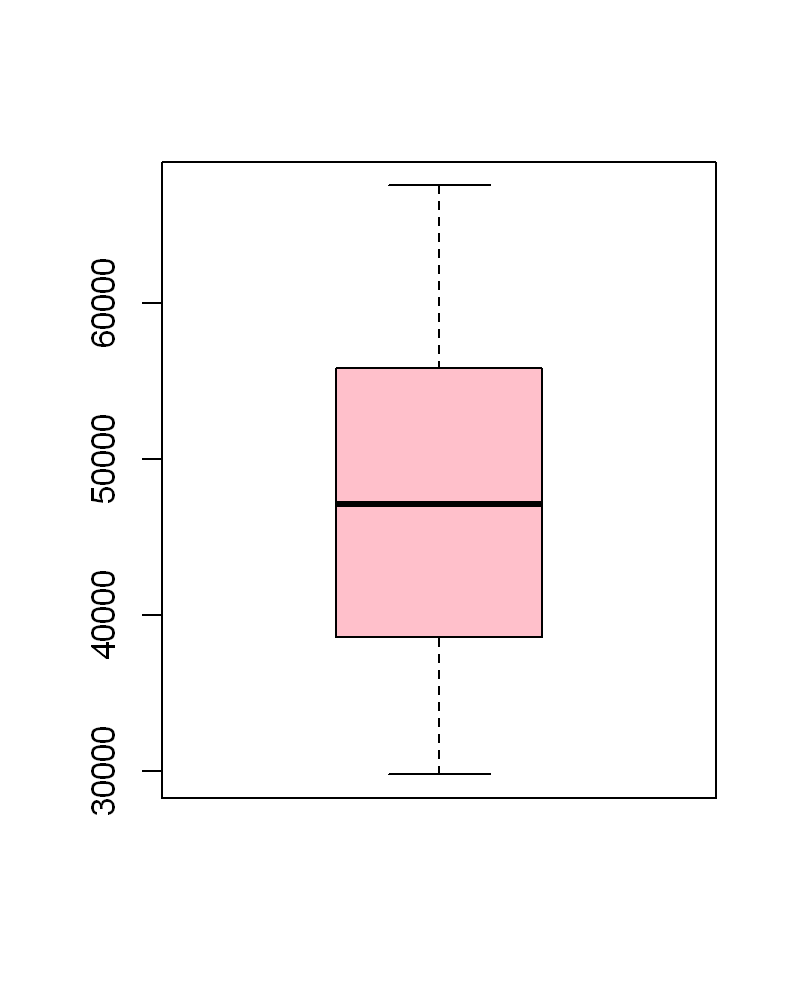

In [15]:
fig(4, 5, 200)
boxplot(BTC_daily$CBBTCUSD, col='pink')

На диаграмме размаха видим, что выбросы в данном ряду отсутствуют.

## Анализ структуры временного ряда

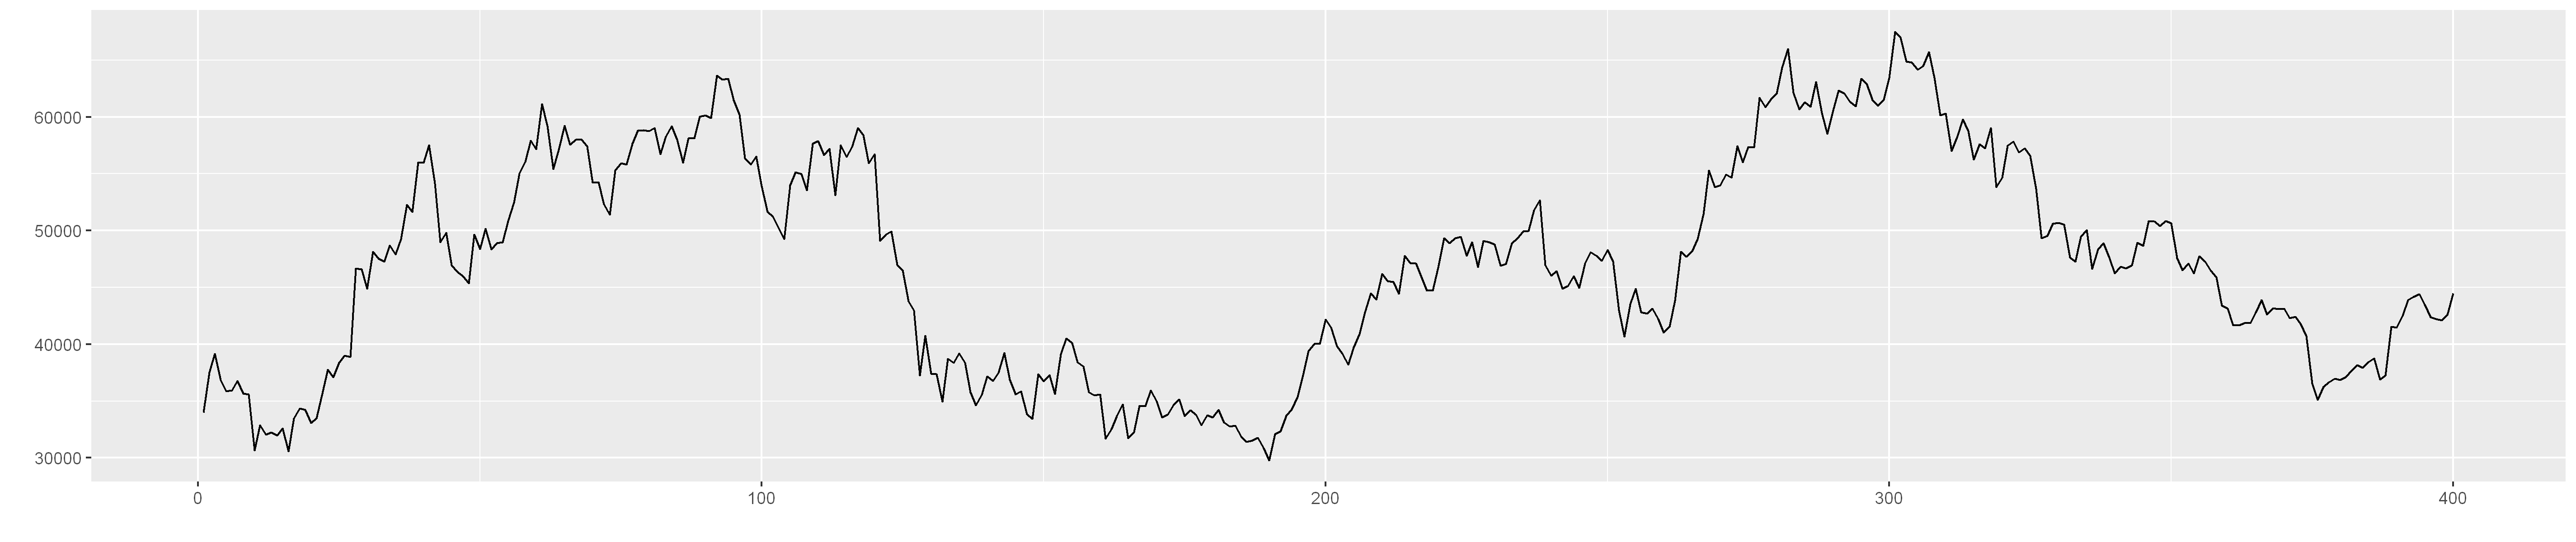

In [16]:
daily.plot <- autoplot(as.ts(BTC_daily$CBBTCUSD))

fig(19, 4, 300)
daily.plot

Для потвеждения текущего тренда можем воспользоваться экспоненциальным сглаживанием ряда:

In [17]:
library(forecast)

Registered S3 methods overwritten by 'forecast':
  method                 from     
  autoplot.Arima         ggfortify
  autoplot.acf           ggfortify
  autoplot.ar            ggfortify
  autoplot.bats          ggfortify
  autoplot.decomposed.ts ggfortify
  autoplot.ets           ggfortify
  autoplot.forecast      ggfortify
  autoplot.stl           ggfortify
  autoplot.ts            ggfortify
  fitted.ar              ggfortify
  fortify.ts             ggfortify
  residuals.ar           ggfortify



In [18]:
BTC_daily_ses <- c(NA, ses(BTC_daily$CBBTCUSD, alpha=0.015, initial='simple')$model$fitted[-1])

Warning message:
"Removed 1 row(s) containing missing values (geom_path)."


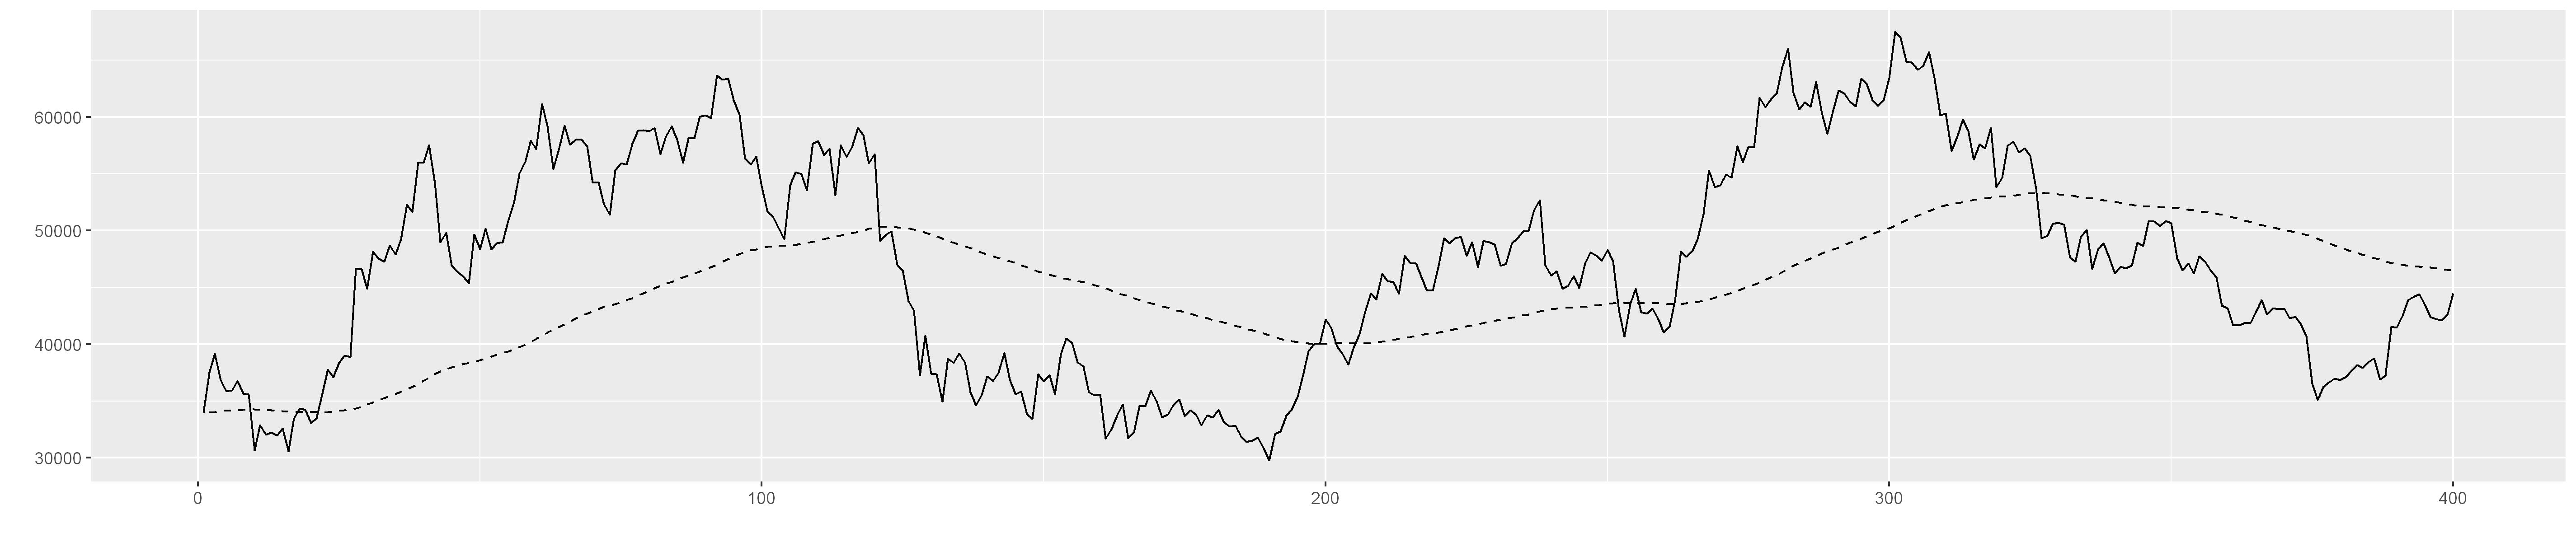

In [19]:
fig(19, 4, 300)
daily.plot +
    geom_line(aes(y=BTC_daily_ses), lty=2)

В ряду наблюдается общая тенденция к росту курса Биткоина. В ряду имеется и детерминированный, и стохастическиц тренд.

## Проверка временного ряда на стационарность

Проверим основные условия стационарности процесса

#### 1. Постоянство математического ожидания ряда

##### Тест Манна-Уитни

В силу того, что данные не распределены нормально, применяем непараметрический критерий Манна-Уитни:

In [20]:
wilcox.test(BTC_daily$CBBTCUSD[1:200], BTC_daily$CBBTCUSD[201:400], alternative='two.sided', paired=FALSE)


	Wilcoxon rank sum test with continuity correction

data:  BTC_daily$CBBTCUSD[1:200] and BTC_daily$CBBTCUSD[201:400]
W = 14365, p-value = 1.096e-06
alternative hypothesis: true location shift is not equal to 0


Рассчитанная статистика является значимой, о чем говорит величина p-значения.

Таким образом, тест позволяет отвергнуть нулевую гипотезу о постоянстве математического ожидания временного ряда.

#### 2. Постоянство дисперсии ряда

##### Тест Сиджела-Тьюки

В силу того, что данные не распределены нормально, применяем непараметрический критерий Сиджела-Тьюки:

In [21]:
library(DescTools)


Присоединяю пакет: 'DescTools'


Следующий объект скрыт от 'package:forecast':

    BoxCox


Следующие объекты скрыты от 'package:psych':

    AUC, ICC, SD




In [22]:
SiegelTukeyTest(BTC_daily$CBBTCUSD[1:200], BTC_daily$CBBTCUSD[201:400], alternative='two.sided')


	Siegel-Tukey-test for equal variability

data:  BTC_daily$CBBTCUSD[1:200] and BTC_daily$CBBTCUSD[201:400]
ST = 32155, p-value = 6.351e-12
alternative hypothesis: true ratio of scales is not equal to 1


p-значение для рассчитанной статистики меньше 0,5, следовательно, отвергаем гипотезу о постоянстве дисперсий двух частей ряда.

#### 3. Отсутствие автокорреляции уровней ряда

Вычислим некоторые выборочные и частные коэффициенты автокорреляции и построим коррелограммы ВАФ и ЧАФ уровней ряда:

In [23]:
acf(BTC_daily$CBBTCUSD, lag.max=12, pl=FALSE) # некоторые значения ВАФ


Autocorrelations of series 'BTC_daily$CBBTCUSD', by lag

    0     1     2     3     4     5     6     7     8     9    10    11    12 
1.000 0.978 0.959 0.941 0.921 0.899 0.877 0.854 0.834 0.815 0.792 0.767 0.742 

In [24]:
pacf(BTC_daily$CBBTCUSD, lag.max=12, pl=FALSE) # некоторые значения ЧАФ


Partial autocorrelations of series 'BTC_daily$CBBTCUSD', by lag

     1      2      3      4      5      6      7      8      9     10     11 
 0.978  0.059  0.021 -0.049 -0.068 -0.034 -0.017  0.052  0.024 -0.106 -0.057 
    12 
-0.031 

In [25]:
library(tsm)

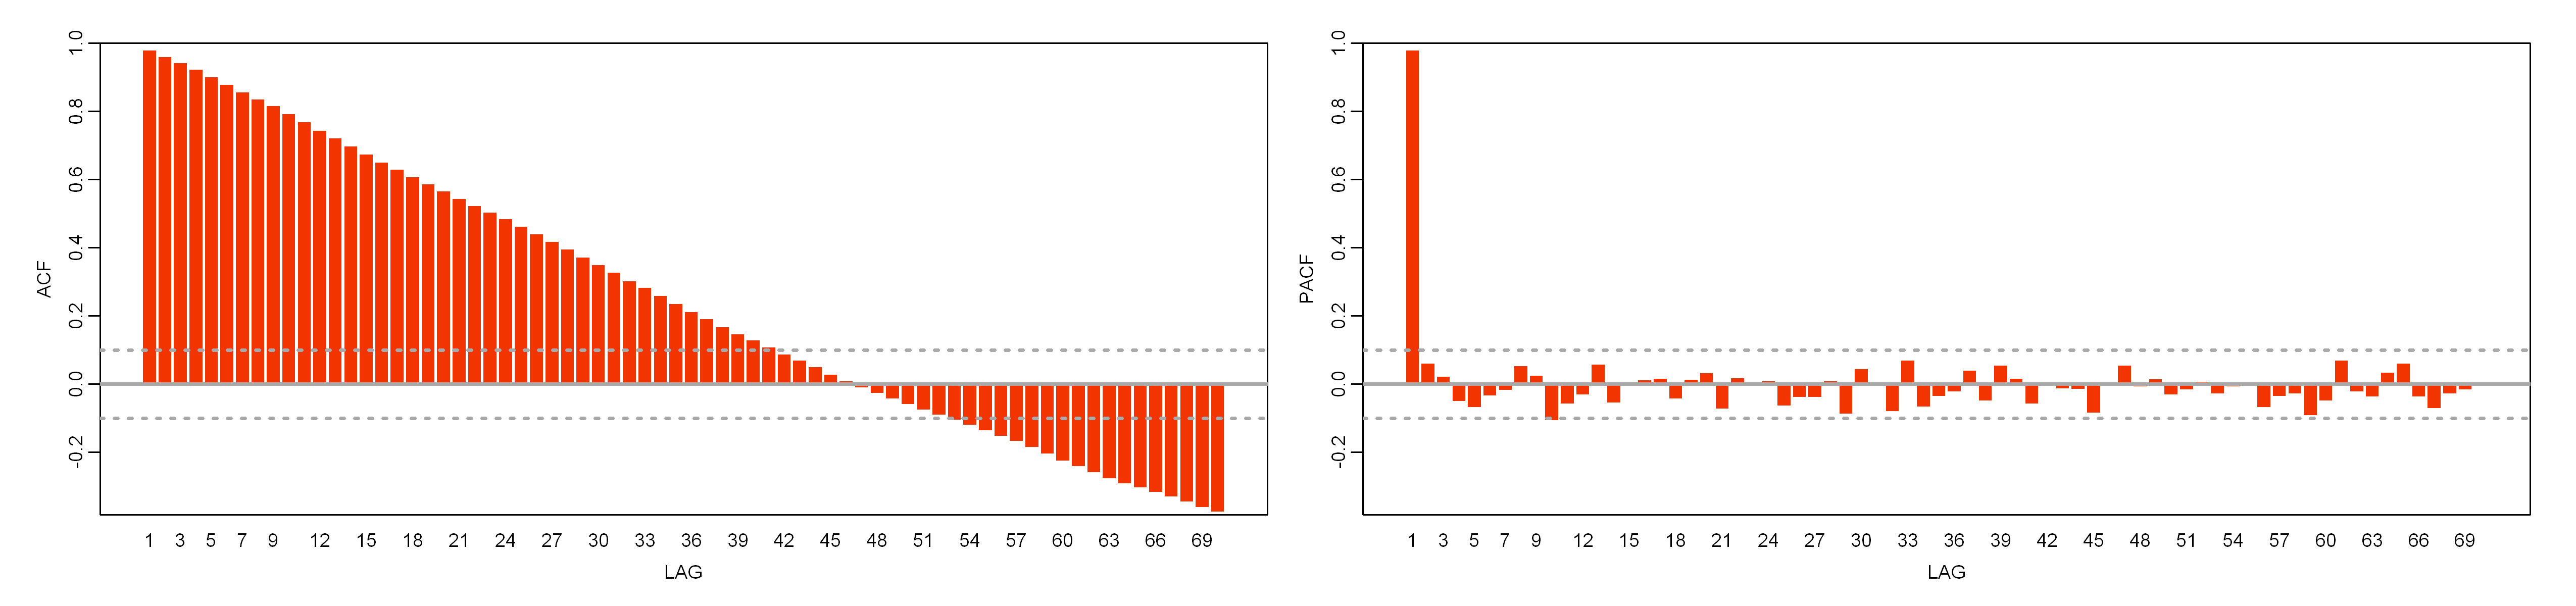

In [26]:
fig(17, 4, 300)
ac(BTC_daily$CBBTCUSD, max.lag=70)

Очевидно, что величина коэффициента автоковариации для данного процесса зависит от момента времени t, а не только от лага. Значения выборочных коэффициентов автокорреляции постепенно падают до нуля. Это также подтверждает нестационарность процесса.  
PACF обрывается на 1-ом лаге, причем величина частного коэффициента автокорреляции для 1-го лага близка к 1. Следовательно, имеем нестационарный процесс авторегрессии 1-го порядка.

Временной ряд является нестационарным (принадлежит к классу линейных нестационарных моделей ARIMA). Поведение ряда определеяется двумя нестационарными компонентами: детерминированным трендом с дрейфом μ (поскольку ВАФ постепенно уходит в отрицательную область) и стохастическим треном. Цикличность отсутствует.  
Предполагаемая форма модели: $y_t = α_0 + α_1 \cdot y_{t-1} + ε_t$.
Очевидно, что $α_1 = 1$ (судя по ACF, PACF и графику процесса), и процесс является случайным блужданием с трендом и дрейфом. Причем, скорее всего, имеем дело с субмартингалом.

#### Тест на единичный корень

Поскольку данные имеют распределение, отличающееся от нормального, расширенный тест Дики-Фуллера, относящийся к параметрическим тестам, применить нельзя.  В качестве альтернативы данному тесту используем непараметрический тест Филлипса-Перрона, устойчивый к неопределенной автокорреляции и гетероскедастичности:

In [27]:
library(tseries)

In [28]:
pp.test(BTC_daily$CBBTCUSD, alternative='stationary', type='Z(t_alpha)')


	Phillips-Perron Unit Root Test

data:  BTC_daily$CBBTCUSD
Dickey-Fuller Z(t_alpha) = -2.1666, Truncation lag parameter = 5,
p-value = 0.5069
alternative hypothesis: stationary


Тест возволяет принять нулевую гипотезу о нестационарности исследуемого ряда, поскольку p-значение рассчитанной статистики > 0,5. Следовательно, ряд является процессом случайного блуждания.

Для дальнейшего моделирования ряд необходимо привести к стационарному виду.

## Приведение ряда к стационарному виду

### Логарифмическая доходность

Перейдем к ряду логарифмической доходности:

In [29]:
BTC_daily_logret <- diff(log(BTC_daily$CBBTCUSD), differences=1)

Построим график ряда лог-доходности:

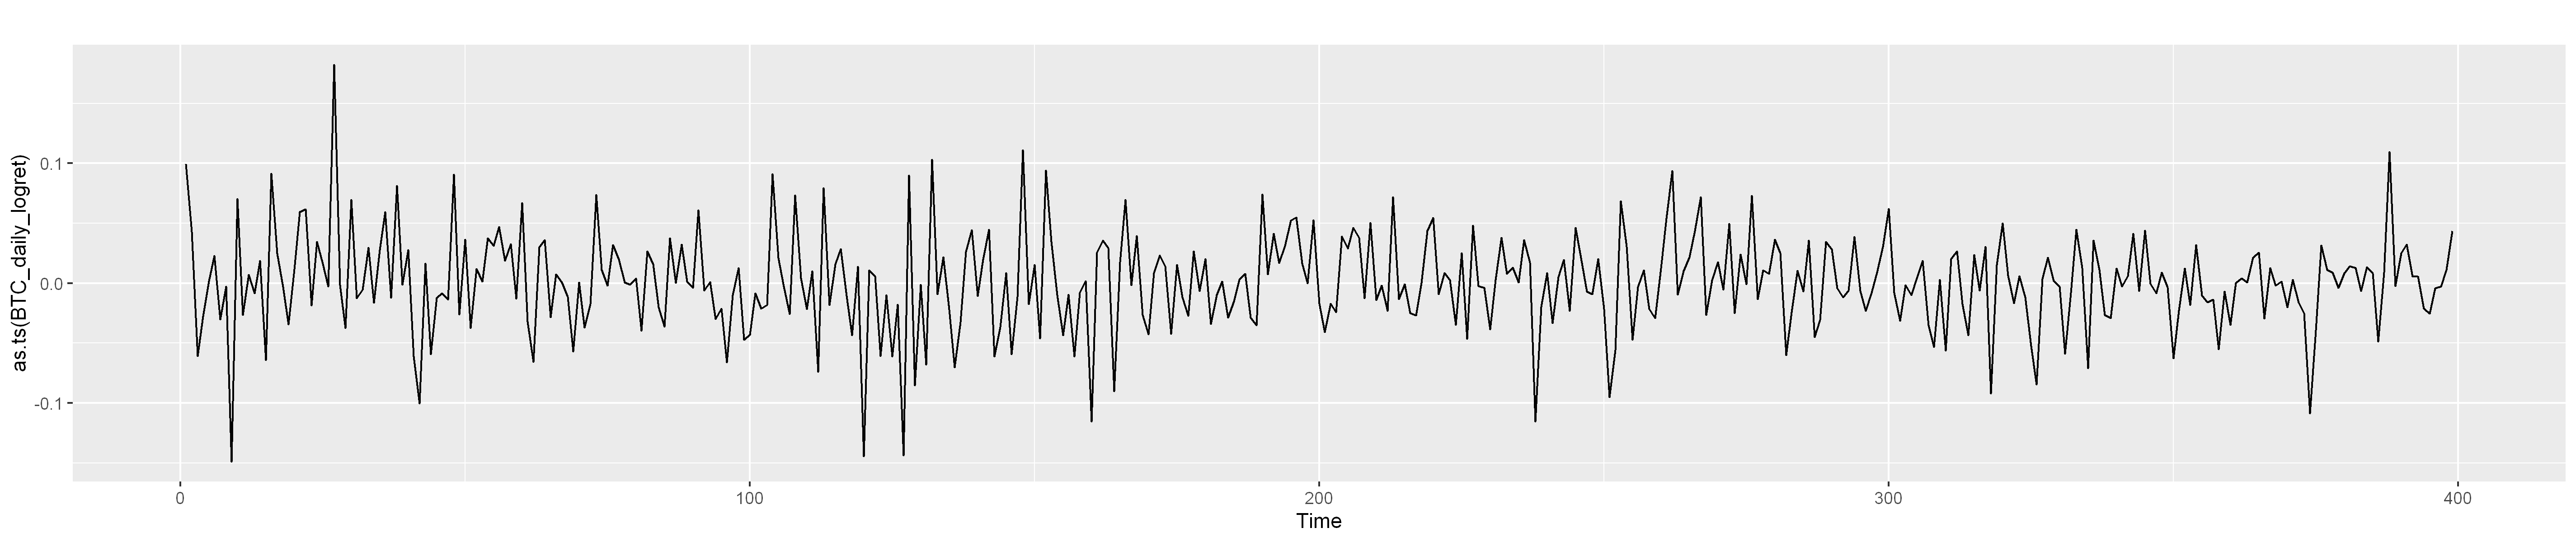

In [30]:
fig(19, 4, 300)
autoplot(as.ts(BTC_daily_logret))

Проверим основные статистические характеристики и распределение полученного ряда:

In [31]:
print(describe(BTC_daily_logret))

   vars   n mean   sd median trimmed  mad   min  max range  skew kurtosis se
X1    1 399    0 0.04      0       0 0.03 -0.15 0.18  0.33 -0.08     1.98  0


Распределение ряда имеет высокое значение избыточного эксцесса, выходящее за пределы допустимых значений [-1; 1].

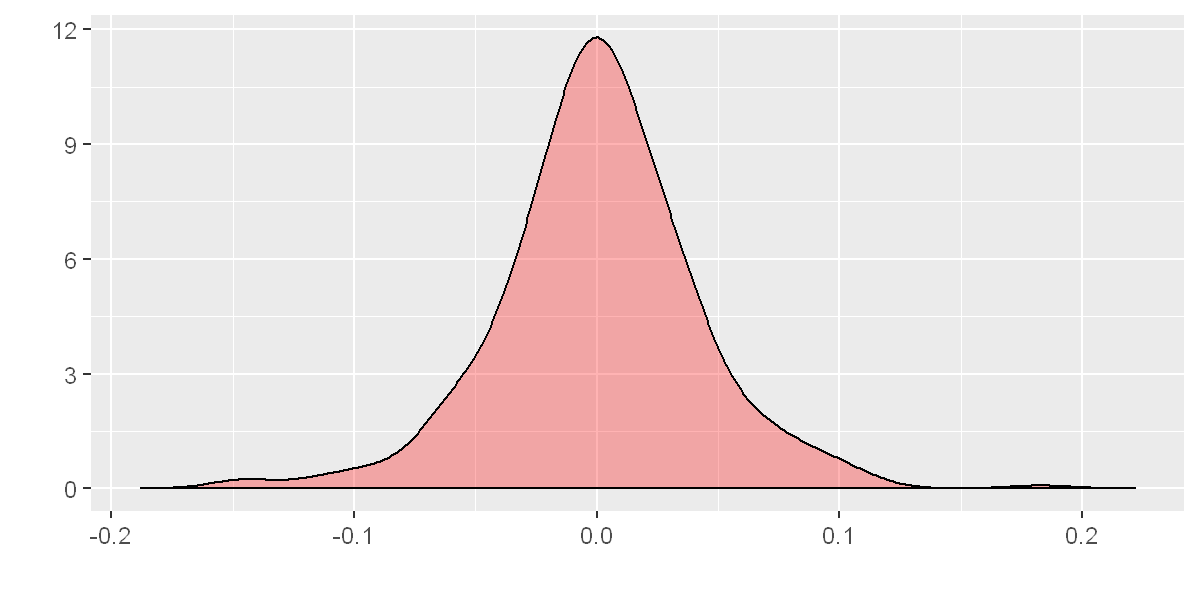

In [32]:
fig(6, 3, 200)
autoplot(density(BTC_daily_logret, adjust=1.45), fill='red')

[1] 27  9

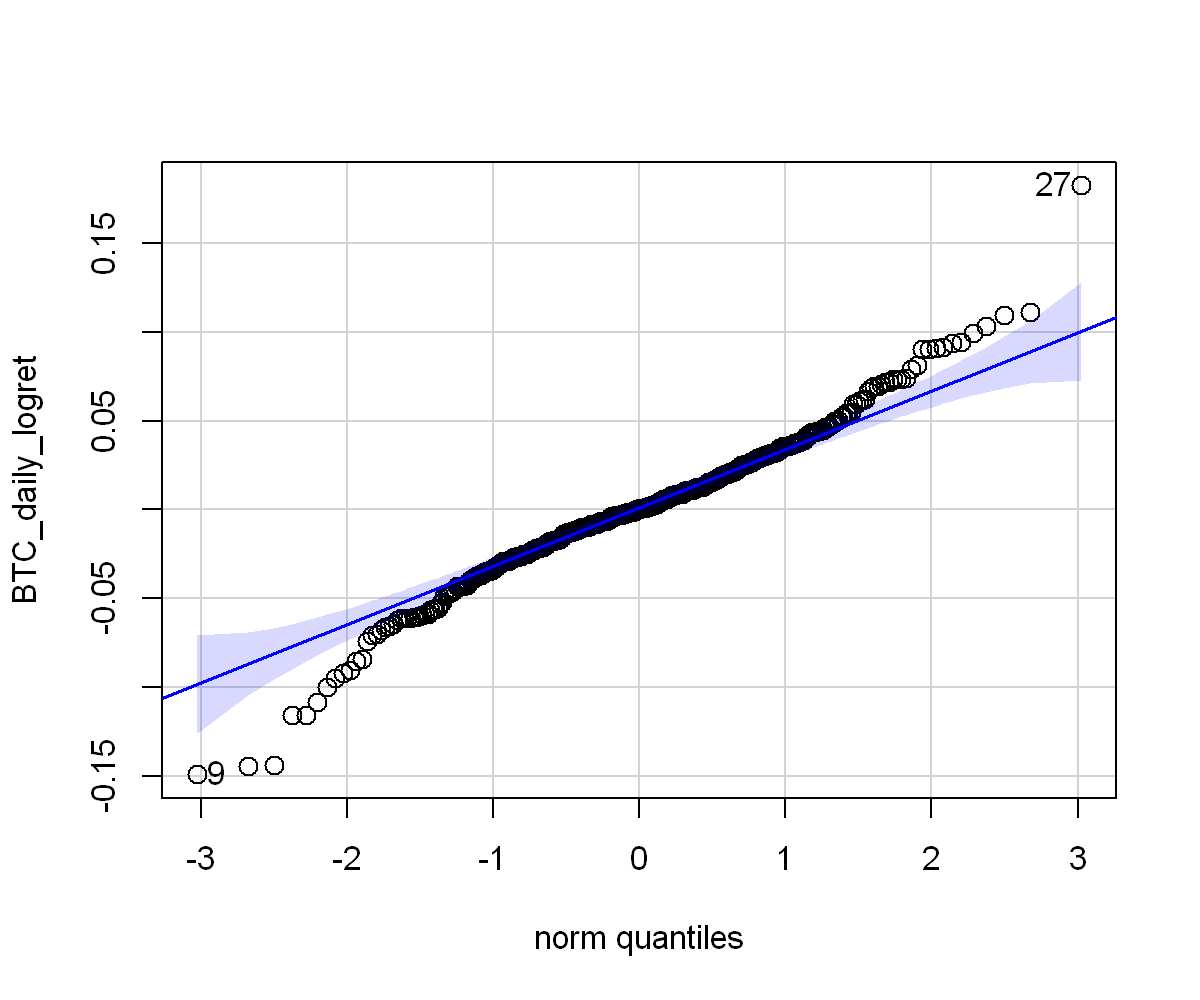

In [33]:
fig(6, 5, 200)
car::qqPlot(BTC_daily_logret,
            cex=1.3, lwd=1.8,
            envelope=list(border=FALSE))

Распределение ряда лог-доходности отлично от нормального.

Проверим полученный ряд на стационарность, применяя непараметрические тесты:

#### 1. Постоянство математического ожидания ряда

##### Тест Манна-Уитни

In [34]:
wilcox.test(BTC_daily_logret[1:200], BTC_daily_logret[201:399], alternative='two.sided', paired=FALSE)


	Wilcoxon rank sum test with continuity correction

data:  BTC_daily_logret[1:200] and BTC_daily_logret[201:399]
W = 19773, p-value = 0.9125
alternative hypothesis: true location shift is not equal to 0


Математическое ожидание ряда является постоянным.

#### 2. Постоянство дисперсии ряда

##### Тест Сиджела-Тьюки

In [35]:
SiegelTukeyTest(BTC_daily_logret[1:200], BTC_daily_logret[201:399], alternative='two.sided')


	Siegel-Tukey-test for equal variability

data:  BTC_daily_logret[1:200] and BTC_daily_logret[201:399]
ST = 3176, p-value = 0.08378
alternative hypothesis: true ratio of scales is not equal to 1


Дисперсии двух частей временного ряда статистически равны.

#### 3. Отсутствие автокорреляции уровней ряда

In [36]:
acf(BTC_daily_logret, lag.max=12, pl=FALSE) # некоторые значения ВАФ


Autocorrelations of series 'BTC_daily_logret', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.060 -0.007  0.010  0.075 -0.002  0.029 -0.070 -0.044  0.065  0.053 
    11     12 
 0.006 -0.090 

In [37]:
pacf(BTC_daily_logret, lag.max=12, pl=FALSE) # некоторые значения ЧАФ


Partial autocorrelations of series 'BTC_daily_logret', by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.060 -0.011  0.009  0.076  0.007  0.031 -0.069 -0.059  0.057  0.058  0.026 
    12 
-0.084 

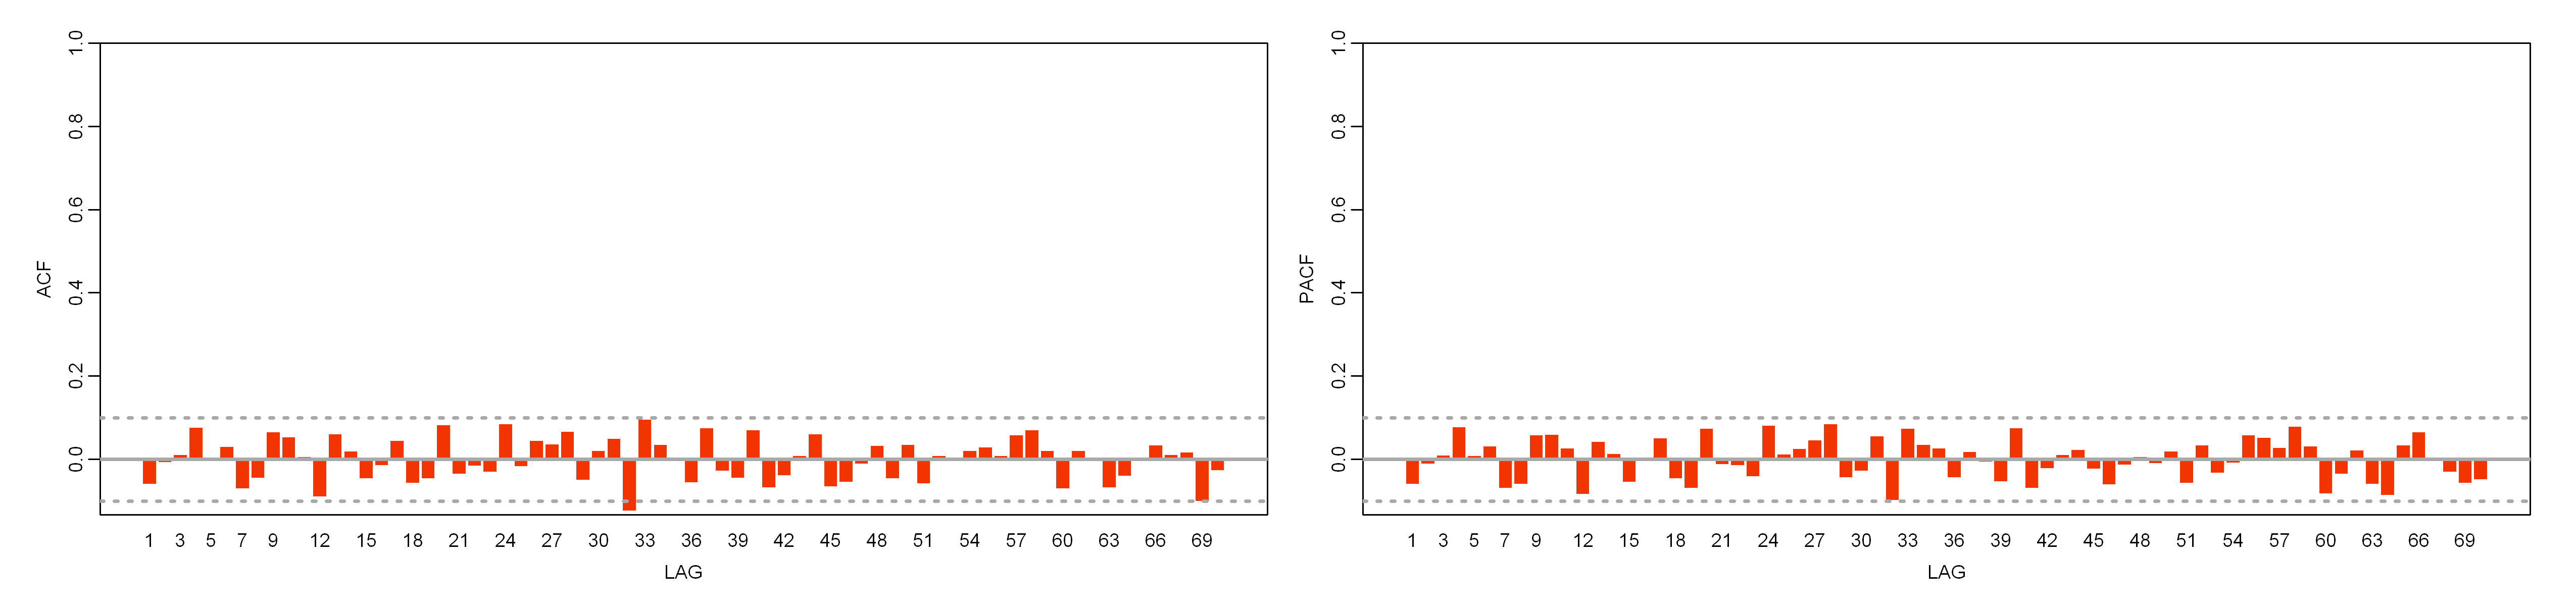

In [38]:
fig(17, 4, 300)
ac(BTC_daily_logret, max.lag=70)

По коррелограммам ВАФ и ЧАФ видим, что ряд лог-доходности ведет себя как "белый шум". По такому ряду нельзя строить модель ARIMA.  
Перейдем к первым разностям ряда лог-доходности:

In [39]:
BTC_daily_logretdiff <- diff(log(BTC_daily$CBBTCUSD), differences=2)

Построим график полученного ряда:

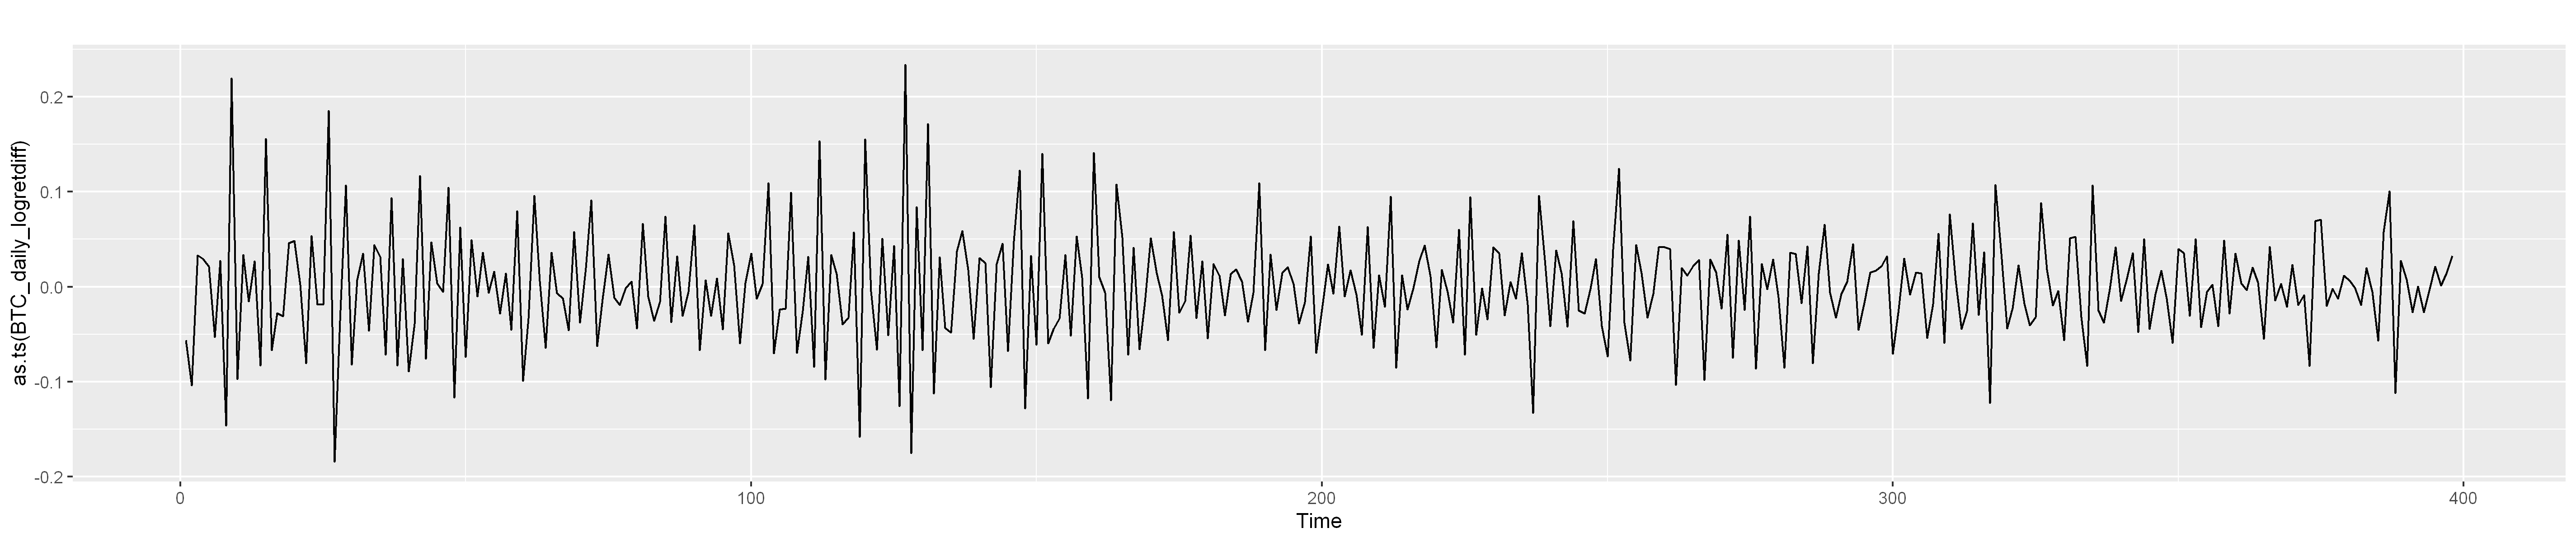

In [40]:
fig(19, 4, 300)
autoplot(as.ts(BTC_daily_logretdiff))

В первой половине ряда заметен эффект кластеризации волатильности. Следовательно, скорее всего, данный ряд окажется нестационарным по условию дисперсии.

Получим основные статистические характеристики данного ряда:

In [41]:
print(describe(BTC_daily_logretdiff))

   vars   n mean   sd median trimmed  mad   min  max range skew kurtosis se
X1    1 398    0 0.06      0       0 0.05 -0.18 0.23  0.42 0.28     1.21  0


Избыточный эксцесс выходит за допустимые пределы [-1; 1]. Присутствует допустимое правостороннее смещение.

Построим график распределения ряда:

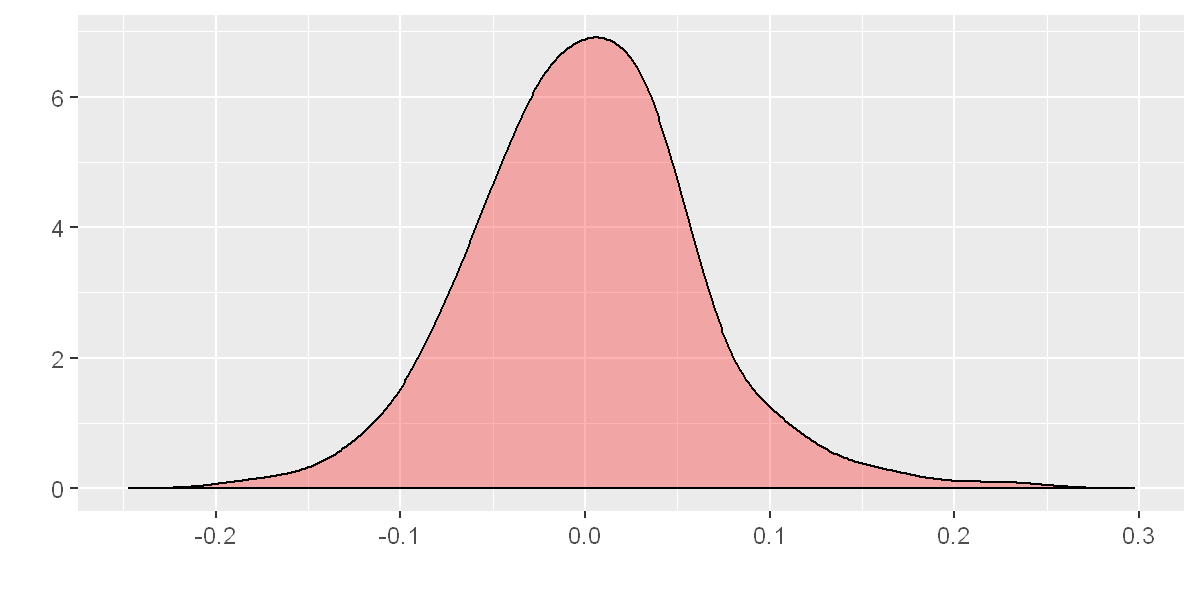

In [42]:
fig(6, 3, 200)
autoplot(density(BTC_daily_logretdiff, adjust=1.45), fill='red')

[1] 127   9

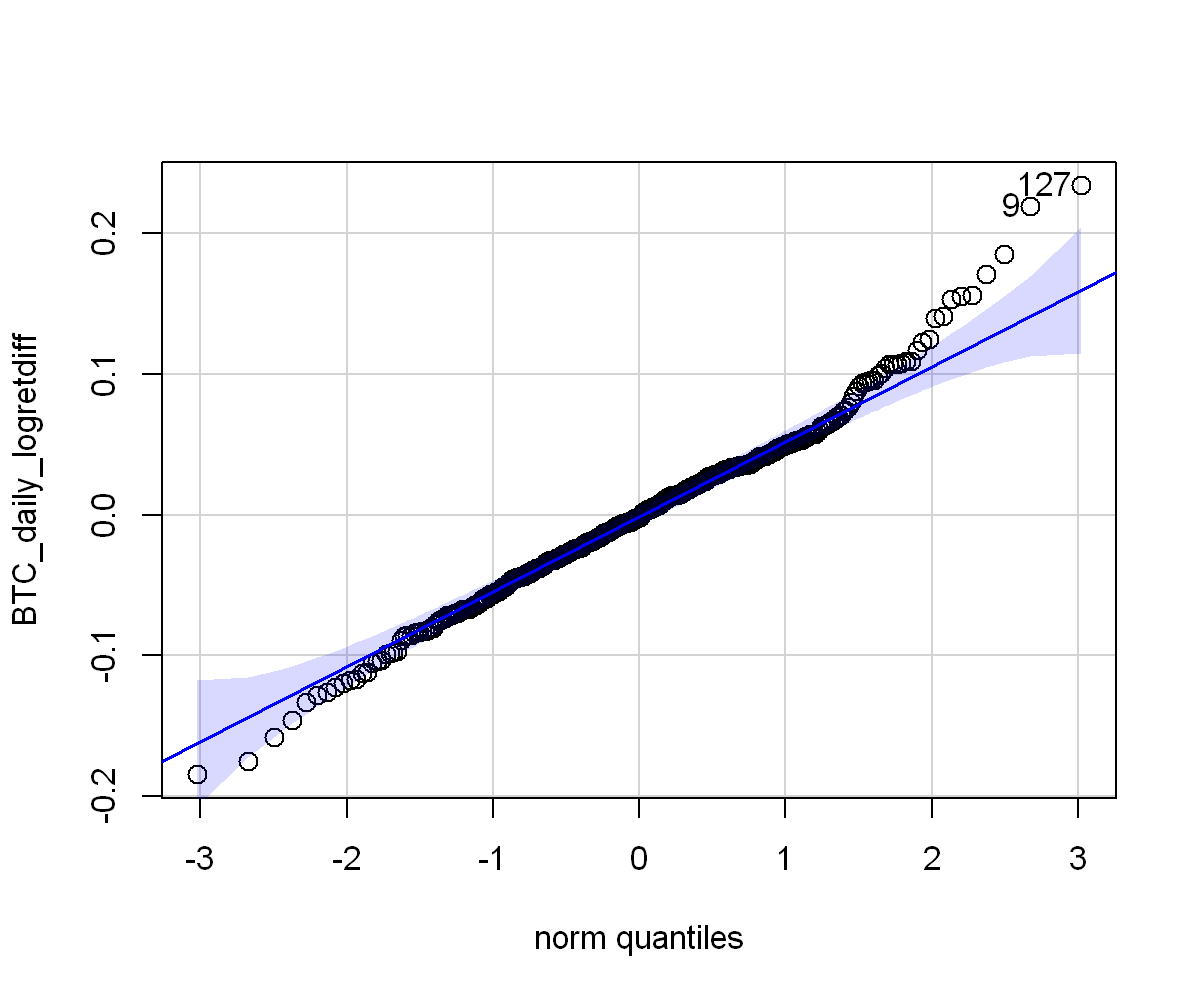

In [43]:
fig(6, 5, 200)
car::qqPlot(BTC_daily_logretdiff,
            cex=1.3, lwd=1.8,
            envelope=list(border=FALSE))

В целом, можем утверждать, что распределение ряда близко к нормальному.

Проверим полученный ряд на стационарность, применяя параметрические тесты:

#### 1. Постоянство дисперсии ряда

##### Тест Фишера

In [44]:
var.test(BTC_daily_logretdiff[1:199], BTC_daily_logretdiff[200:398], alternative='two.sided')


	F test to compare two variances

data:  BTC_daily_logretdiff[1:199] and BTC_daily_logretdiff[200:398]
F = 2.2763, num df = 198, denom df = 198, p-value = 1.189e-08
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 1.721432 3.009935
sample estimates:
ratio of variances 
          2.276268 


##### Тест Бартлетта

In [45]:
bartlett.test(list(BTC_daily_logretdiff[1:199], BTC_daily_logretdiff[200:398]))


	Bartlett test of homogeneity of variances

data:  list(BTC_daily_logretdiff[1:199], BTC_daily_logretdiff[200:398])
Bartlett's K-squared = 32.504, df = 1, p-value = 1.189e-08


##### Тест Кокрена

In [46]:
# делим ряд на 3 части и находим их дисперсии
var1 <- var(BTC_daily_logretdiff[1:133])
var2 <- var(BTC_daily_logretdiff[134:266])
var3 <- var(BTC_daily_logretdiff[267:398])
outliers::cochran.test(object=c(var1, var2, var3), data=c(133, 133, 132))


	Cochran test for outlying variance

data:  c(var1, var2, var3)
C = 0.52875, df = 132.67, k = 3.00, p-value = 4.502e-08
alternative hypothesis: Group 1 has outlying variance
sample estimates:
          1           2           3 
0.005521120 0.002948728 0.001972026 


По результатам всех трех тестов отвергаем гипотезу о постоянстве дисперсии временного ряда.

#### 2. Постоянство математического ожидания ряда

##### Тест Стьюдента

In [47]:
t.test(BTC_daily_logretdiff[1:199], BTC_daily_logretdiff[200:398], alternative='two.sided', var.equal=FALSE)


	Welch Two Sample t-test

data:  BTC_daily_logretdiff[1:199] and BTC_daily_logretdiff[200:398]
t = -0.15076, df = 343.82, p-value = 0.8803
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.01251578  0.01073369
sample estimates:
    mean of x     mean of y 
-0.0005858787  0.0003051685 


##### Тест Фишера

In [48]:
var1 <- var(BTC_daily_logretdiff[1:133])
var2 <- var(BTC_daily_logretdiff[134:266])
var3 <- var(BTC_daily_logretdiff[267:398])
var_mean <- sum(c(var1 * (133 - 1), var2 * (133 - 1), var3 * (132 - 1))) / (398 - 3)  # средняя дисперсия временного ряда 
mean1 <- mean(BTC_daily_logretdiff[1:133])
mean2 <- mean(BTC_daily_logretdiff[134:266])
mean3 <- mean(BTC_daily_logretdiff[267:398])
F.stat <- sum(((c(mean1, mean2, mean3) - mean(BTC_daily_logretdiff)) ^ 2) * c(133, 133, 132)) / ((3 - 1) * var_mean)
F.crit <- qf(0.975, 3 - 1, 398 - 3)
print(F.stat)
print(F.crit)

[1] 0.008982711
[1] 3.723545


Результаты обоих тестов позволяют принять гипотезу о постоянстве математического ожидания.

#### 3. Отсутствие автокорреляции уровней ряда

In [49]:
acf(BTC_daily_logretdiff, lag.max=12, pl=FALSE) # некоторые значения ВАФ


Autocorrelations of series 'BTC_daily_logretdiff', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.524  0.025 -0.025  0.066 -0.053  0.065 -0.061 -0.030  0.042  0.024 
    11     12 
 0.017 -0.112 

In [50]:
pacf(BTC_daily_logretdiff, lag.max=12, pl=FALSE) # некоторые значения ЧАФ


Partial autocorrelations of series 'BTC_daily_logretdiff', by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.524 -0.345 -0.295 -0.163 -0.154 -0.039 -0.054 -0.137 -0.119 -0.064  0.034 
    12 
-0.097 

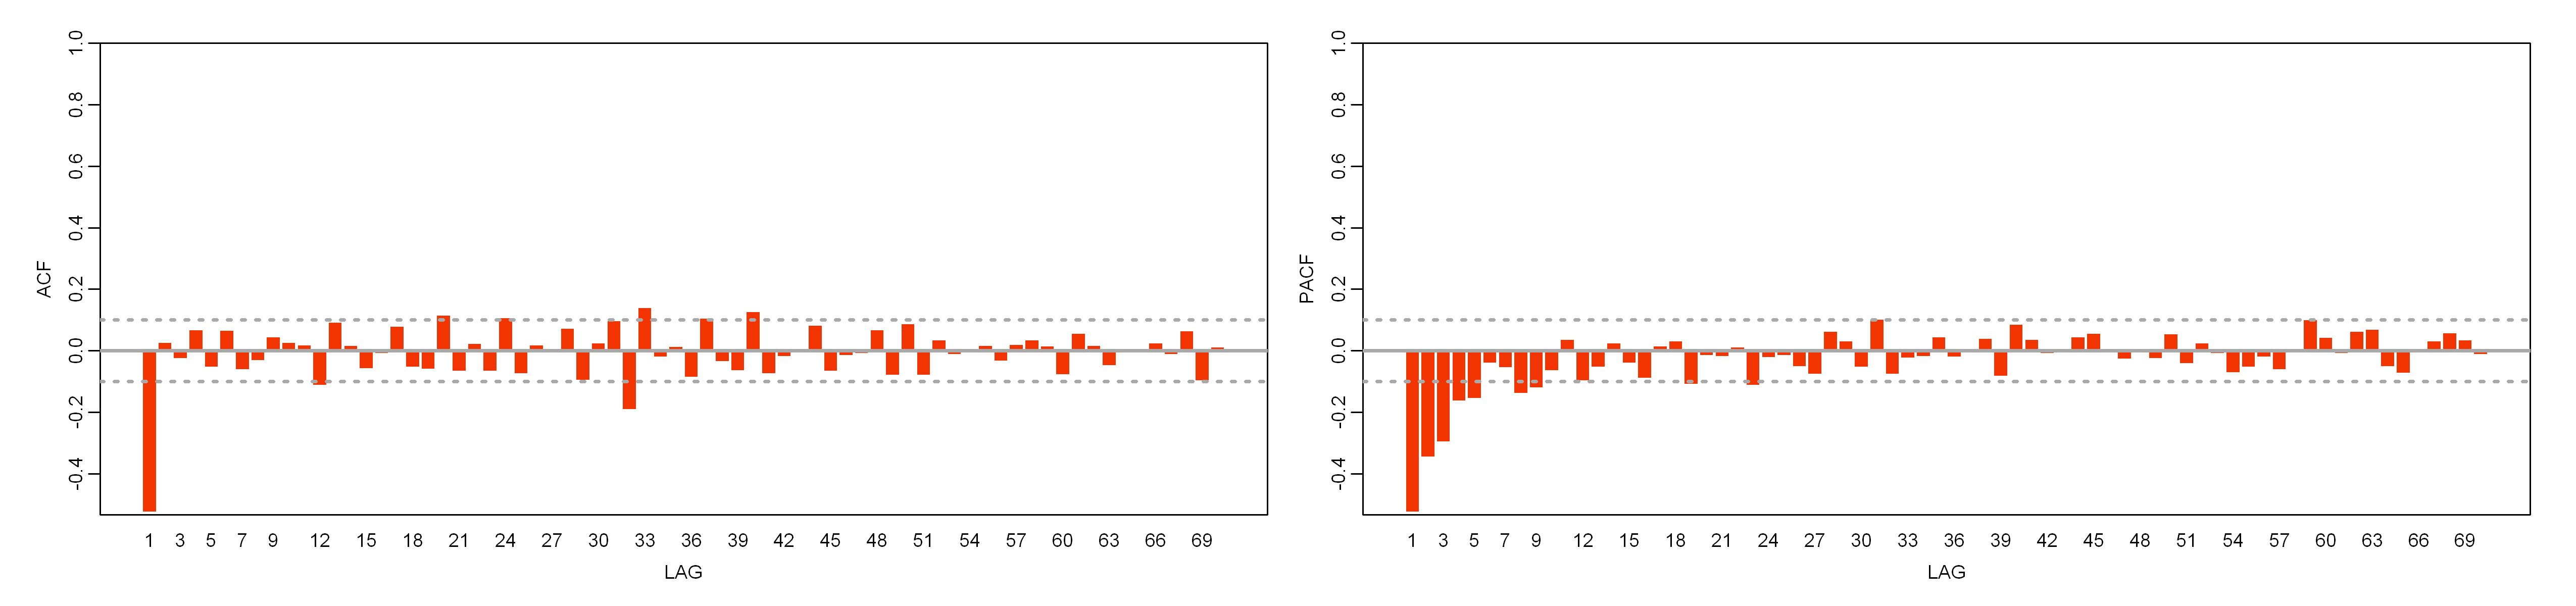

In [51]:
fig(17, 4, 300)
ac(BTC_daily_logretdiff, max.lag=70)

В коррелограммах ВАФ и ЧАФ ряда 1-ых разностей лог-доходности заметны общие черты коррелограмм процесса MA(1). Однако видим, что значение выборочного коэффициента автокорреляции для 1-го лага стало < -0,5, следовательно, ряд является чрезмерно интегрированным. Поэтому модель скользящего среднего строить не можем. По данному ряду будем строить модель AR(1), а на остатках данной модели будем строить модель семейства ARCH/GARCH.

## Построение моделей ARIMA(p, d, q)-GARCH(h, l)

Строим модель AR(1) по ряду 1-ых разностей лог-доходности:

In [52]:
logretdiff_arima <- Arima(BTC_daily_logretdiff, order=c(1, 0, 0), include.constant=TRUE)
summary(logretdiff_arima)

Series: BTC_daily_logretdiff 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
          ar1     mean
      -0.5243  -0.0001
s.e.   0.0427   0.0016

sigma^2 = 0.002518:  log likelihood = 626.95
AIC=-1247.9   AICc=-1247.84   BIC=-1235.94

Training set error measures:
                        ME       RMSE       MAE      MPE     MAPE      MASE
Training set -5.313013e-05 0.05005709 0.0383846 58.75818 172.4051 0.4909531
                   ACF1
Training set -0.1824606

Получим доверительный интервал для оценки коэффициента:

In [53]:
print(logretdiff_arima$coef)

          ar1     intercept 
-0.5243321457 -0.0001198052 


In [54]:
print(confint(logretdiff_arima))

                 2.5 %       97.5 %
ar1       -0.607945674 -0.440718618
intercept -0.003350303  0.003110692


Оценка параметра $α_1$ статистически значима, так как доверительный интервал не пересек значения 0.

Полученная модель имеет вид: $Δz_t = -0.5243 \cdot Δz_{t-1}$,  
где $Δz_t = z_t - z_{t-1}$,  
$z_t = \ln(\frac{y_t} {y_{t-1}}) = \ln(y_t) - \ln(y_{t-1})$.

Проверим все необходимые свойства и ограничения, накладываемые на коэффициенты модели и характеристики процесса:

1. $α_1 ≠ 1$:

In [55]:
print(logretdiff_arima$coef[1] != 1)

 ar1 
TRUE 


Условие выполняется.

2. $|α_1| < 1$:

In [56]:
print(abs(logretdiff_arima$coef[1]) < 1)

 ar1 
TRUE 


Условие выполняется.

Отобразим величину, обратную корню характеристического уравнения для данной модели, на графике:

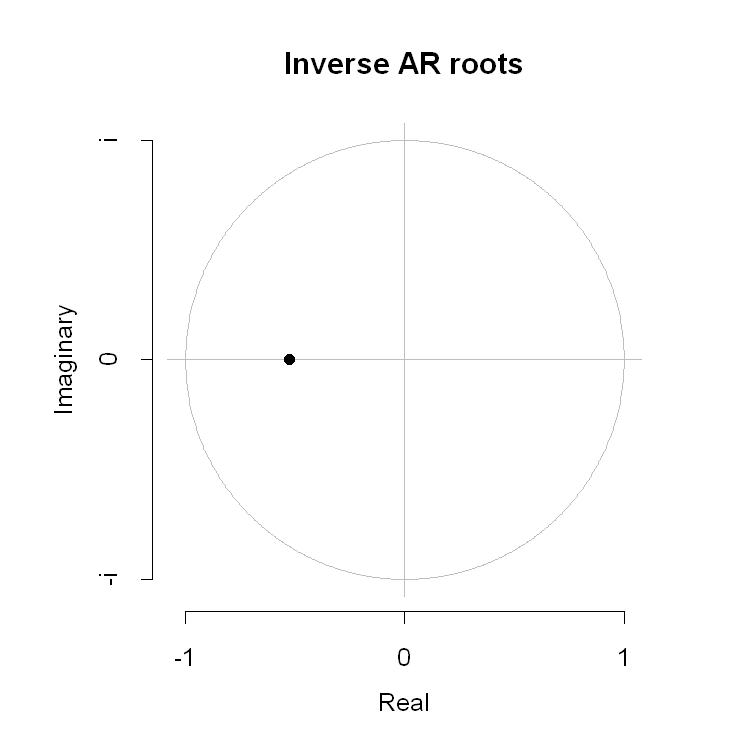

In [57]:
fig(5, 5, 150)
plot(logretdiff_arima)

Видим, что корень характеристического уравнения находится за пределами единичной окружности.  
Таким образом, процесс стационарне и обратим.

3. $ρ_1 = ρ ̃_1 = α_1$:

In [58]:
acf_1 <- acf(BTC_daily_logretdiff, lag.max=1, pl=FALSE)$acf[2]
pacf_1 <- pacf(BTC_daily_logretdiff, lag.max=1, pl=FALSE)$acf[1]
a_1 <- logretdiff_arima$coef[[1]]
a_0 <- logretdiff_arima$coef[[2]]

print(acf_1)  # выборочный коэффициент автокорреляции для лага 1
print(pacf_1)  # частный коэффициент автокорреляции для лага 1
print(a_1)  # оценка параметра модели

[1] -0.5240358
[1] -0.5240358
[1] -0.5243321


Условие выполняется.  
Таким образом, модель удовлетворяет всем ограничениям.

Проверим остатки полученной модели на соответствие "белому шуму":

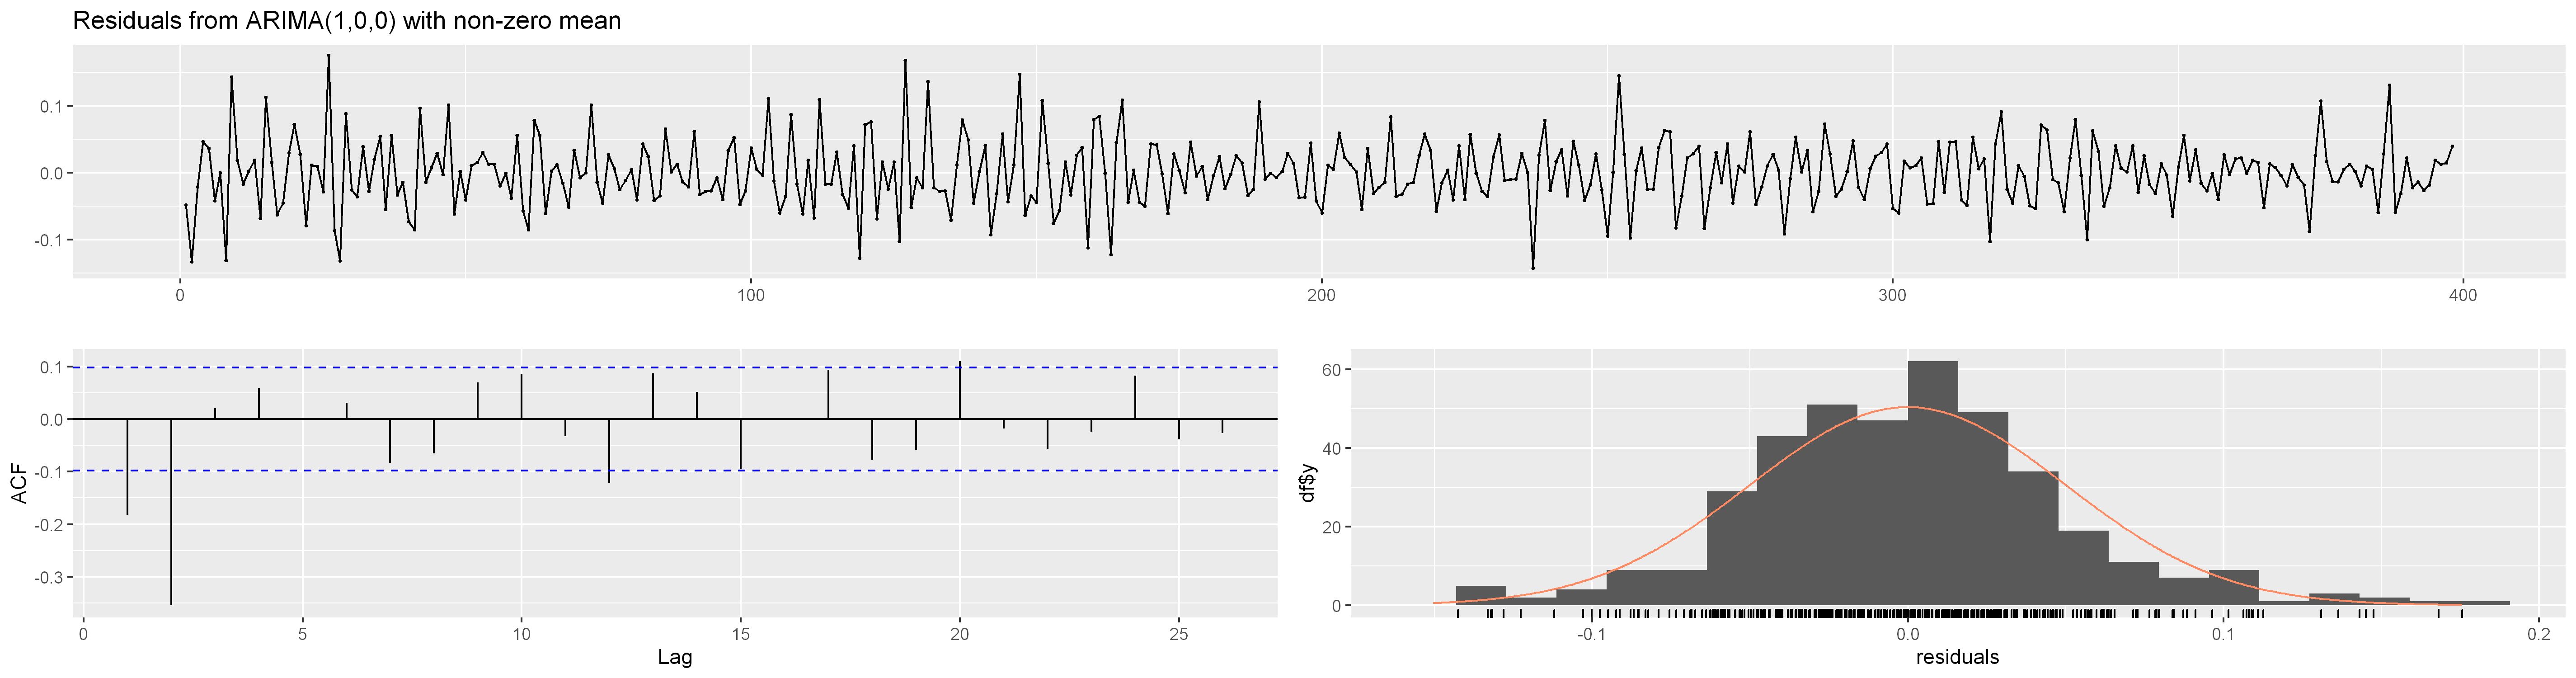

In [59]:
fig(19, 5, 300)
checkresiduals(logretdiff_arima, test=FALSE)

Получим описательные статистики для ряда остатков модели:

In [60]:
print(describe(logretdiff_arima$residuals))

   vars   n mean   sd median trimmed  mad   min  max range skew kurtosis se
X1    1 398    0 0.05      0       0 0.04 -0.14 0.18  0.32 0.28     0.83  0


Коэффициенты асимметрии и избыточного эксцесса лежат в допустимых границах отклонений [-1; 1]. Распределение ряда остатков близко к нормальному. Поэтому для тестирования постоянства математического ожидания и дисперсии ряда остатков используем параметрические тесты.

#### 1. Постоянство дисперсии ряда

##### Тест Фишера

In [61]:
var.test(logretdiff_arima$residuals[1:199], logretdiff_arima$residuals[200:398], alternative='two.sided')


	F test to compare two variances

data:  logretdiff_arima$residuals[1:199] and logretdiff_arima$residuals[200:398]
F = 1.7074, num df = 198, denom df = 198, p-value = 0.000186
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 1.291262 2.257780
sample estimates:
ratio of variances 
           1.70745 


In [62]:
var(logretdiff_arima$residuals[1:199])  # дисперсия 1-ой части ряда остатков

[1] 0.00317617

In [63]:
var(logretdiff_arima$residuals[200:398])  # дисперсия 2-ой части ряда остатков

[1] 0.001860184

##### Тест Бартлетта

In [64]:
bartlett.test(list(logretdiff_arima$residuals[1:199], logretdiff_arima$residuals[200:398]))


	Bartlett test of homogeneity of variances

data:  list(logretdiff_arima$residuals[1:199], logretdiff_arima$residuals[200:398])
Bartlett's K-squared = 13.967, df = 1, p-value = 0.000186


##### Тест Кокрена

In [65]:
var1 <- var(logretdiff_arima$residuals[1:133])
var2 <- var(logretdiff_arima$residuals[134:266])
var3 <- var(logretdiff_arima$residuals[267:398])
outliers::cochran.test(object=c(var1, var2, var3), data=c(133, 133, 132))


	Cochran test for outlying variance

data:  c(var1, var2, var3)
C = 0.44595, df = 132.67, k = 3.00, p-value = 0.001807
alternative hypothesis: Group 1 has outlying variance
sample estimates:
          1           2           3 
0.003374370 0.002504072 0.001688236 


По результатам трех тестов отвергаем гипотезу о постоянстве дисперсии временного ряда.

#### 2. Постоянство и равенство нулю математического ожидания ряда

##### Тест Стьюдента

In [66]:
t.test(logretdiff_arima$residuals[1:199], logretdiff_arima$residuals[200:398], alternative='two.sided', var.equal=FALSE)


	Welch Two Sample t-test

data:  logretdiff_arima$residuals[1:199] and logretdiff_arima$residuals[200:398]
t = -0.17165, df = 370.69, p-value = 0.8638
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.01075588  0.00902884
sample estimates:
    mean of x     mean of y 
-0.0004848906  0.0003786303 


##### Тест Фишера

In [67]:
var1 <- var(logretdiff_arima$residuals[1:133])
var2 <- var(logretdiff_arima$residuals[134:266])
var3 <- var(logretdiff_arima$residuals[267:398])
var_mean <- sum(c(var1 * (133 - 1), var2 * (133 - 1), var3 * (132 - 1))) / (398 - 3)
mean1 <- mean(logretdiff_arima$residuals[1:133])
mean2 <- mean(logretdiff_arima$residuals[134:266])
mean3 <- mean(logretdiff_arima$residuals[267:398])
F.stat <- sum(((c(mean1, mean2, mean3) - mean(logretdiff_arima$residuals)) ^ 2) * c(133, 133, 132)) / ((3 - 1) * var_mean)
F.crit <- qf(0.975, 3 - 1, 398 - 3)
print(F.stat)
print(F.crit)

[1] 0.03152137
[1] 3.723545


Оба теста позволяют принять гипотезу о постоянстве мат. ожидания ряда остатков.

In [68]:
mean(logretdiff_arima$residuals)  # среднее значение ряда остатков

[1] -5.313013e-05

#### 3. Отсутствие автокорреляции уровней ряда

Для проверки значимости сразу нескольких коэффициентов корреляции используем тесты Льюнга-Бокса и Бокса-Пирса по первым 10-и лагам:

##### Тест Льюнга-Бокса

In [69]:
Box.test(logretdiff_arima$residuals, lag=10, type='Ljung')


	Box-Ljung test

data:  logretdiff_arima$residuals
X-squared = 75.581, df = 10, p-value = 3.667e-12


##### Тест Бокса-Пирса

In [70]:
Box.test(logretdiff_arima$residuals, lag=10, type='Box-Pierce')


	Box-Pierce test

data:  logretdiff_arima$residuals
X-squared = 74.689, df = 10, p-value = 5.469e-12


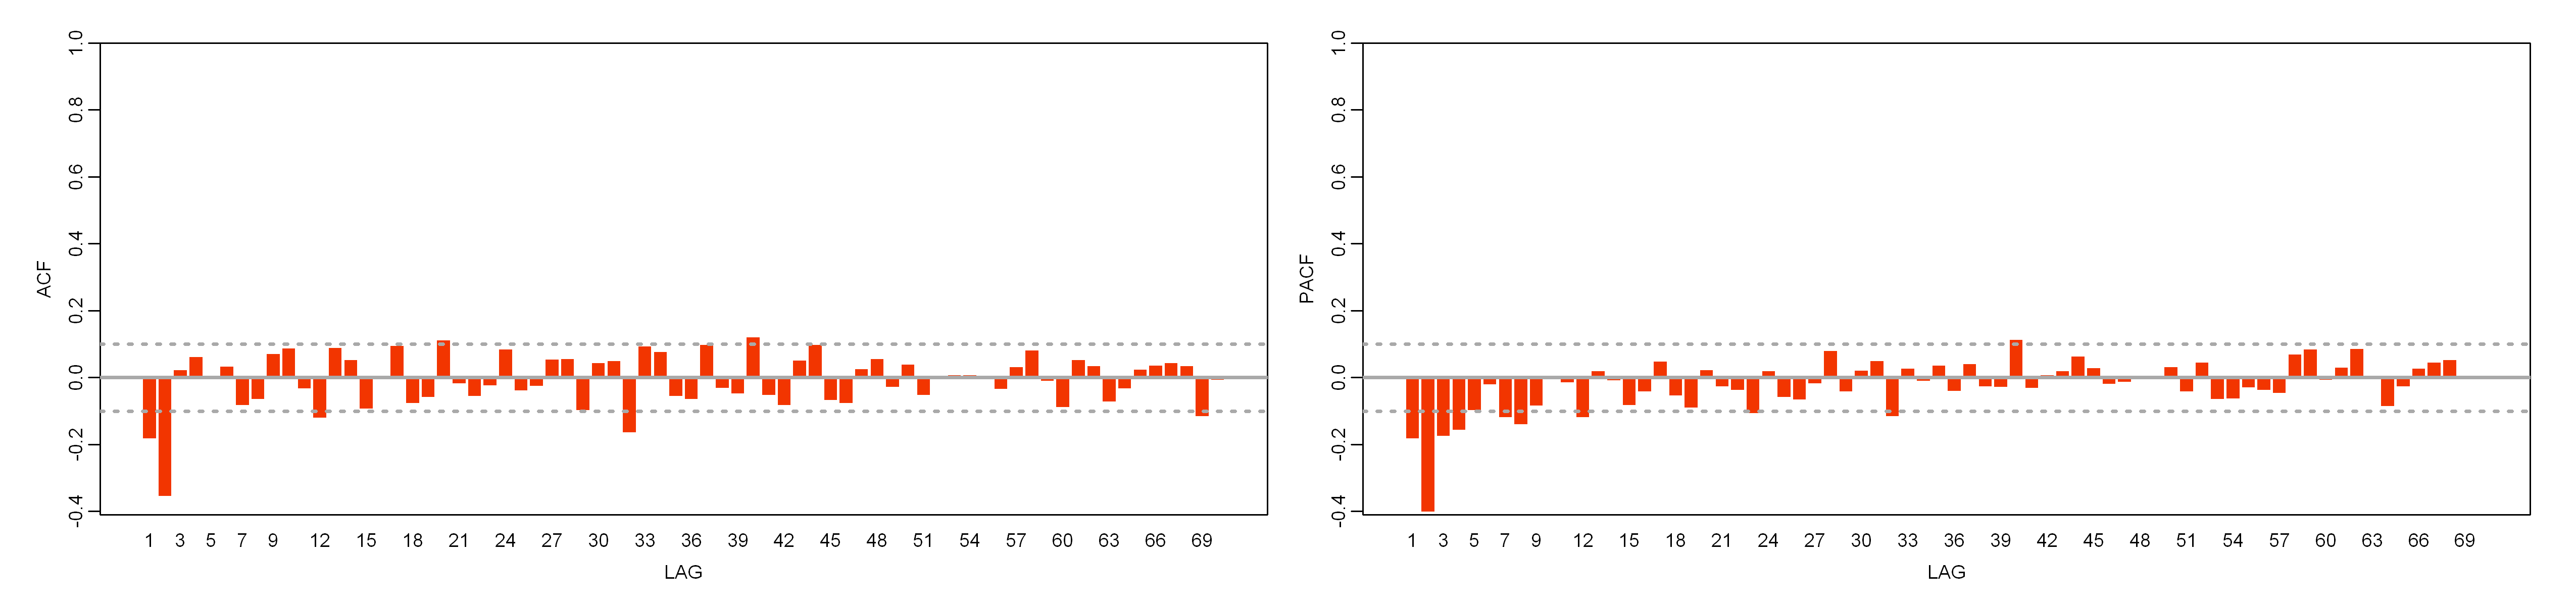

In [71]:
fig(17, 4, 300)
ac(logretdiff_arima$residuals, max.lag=70)

Отвергаем гипотезу об отсутствии автокорреляции в ряду остатков.

Несмотря на нарушение ограничений, можем утверждать, что построенная модель может быть использована для прогноза, так как модели семейства AR(p) не имеют жестких ограничений на стационарность, однако поскольку в ряду остатков присутствует автокорреляция, то ряд остатков модели необходимо домоделировать моделью авторегрессионной условной гетероскедастичности ARCH(h) или GARCH(h, l).

Для подтверждения наличия ARCH-эффектов воспользуемся тестами Льюнга-Бокса и Бокса-Пирса для ряда квадратов остатков модели, поскольку квадраты остатков аналогичны дисперсии:

##### Тест Льюнга-Бокса

In [72]:
Box.test(logretdiff_arima$residuals ^ 2, lag=10, type='Ljung')


	Box-Ljung test

data:  logretdiff_arima$residuals^2
X-squared = 18.731, df = 10, p-value = 0.04381


##### Тест Бокса-Пирса

In [73]:
Box.test(logretdiff_arima$residuals ^ 2, lag=10, type='Box-Pierce')


	Box-Pierce test

data:  logretdiff_arima$residuals^2
X-squared = 18.459, df = 10, p-value = 0.0477


Оба критерия показывают наличие автокорреляции в ряду квадратов остатков. Подтвердим это, построив коррелограммы ВАФ и ЧАФ для ряда квадратов остатков модели:

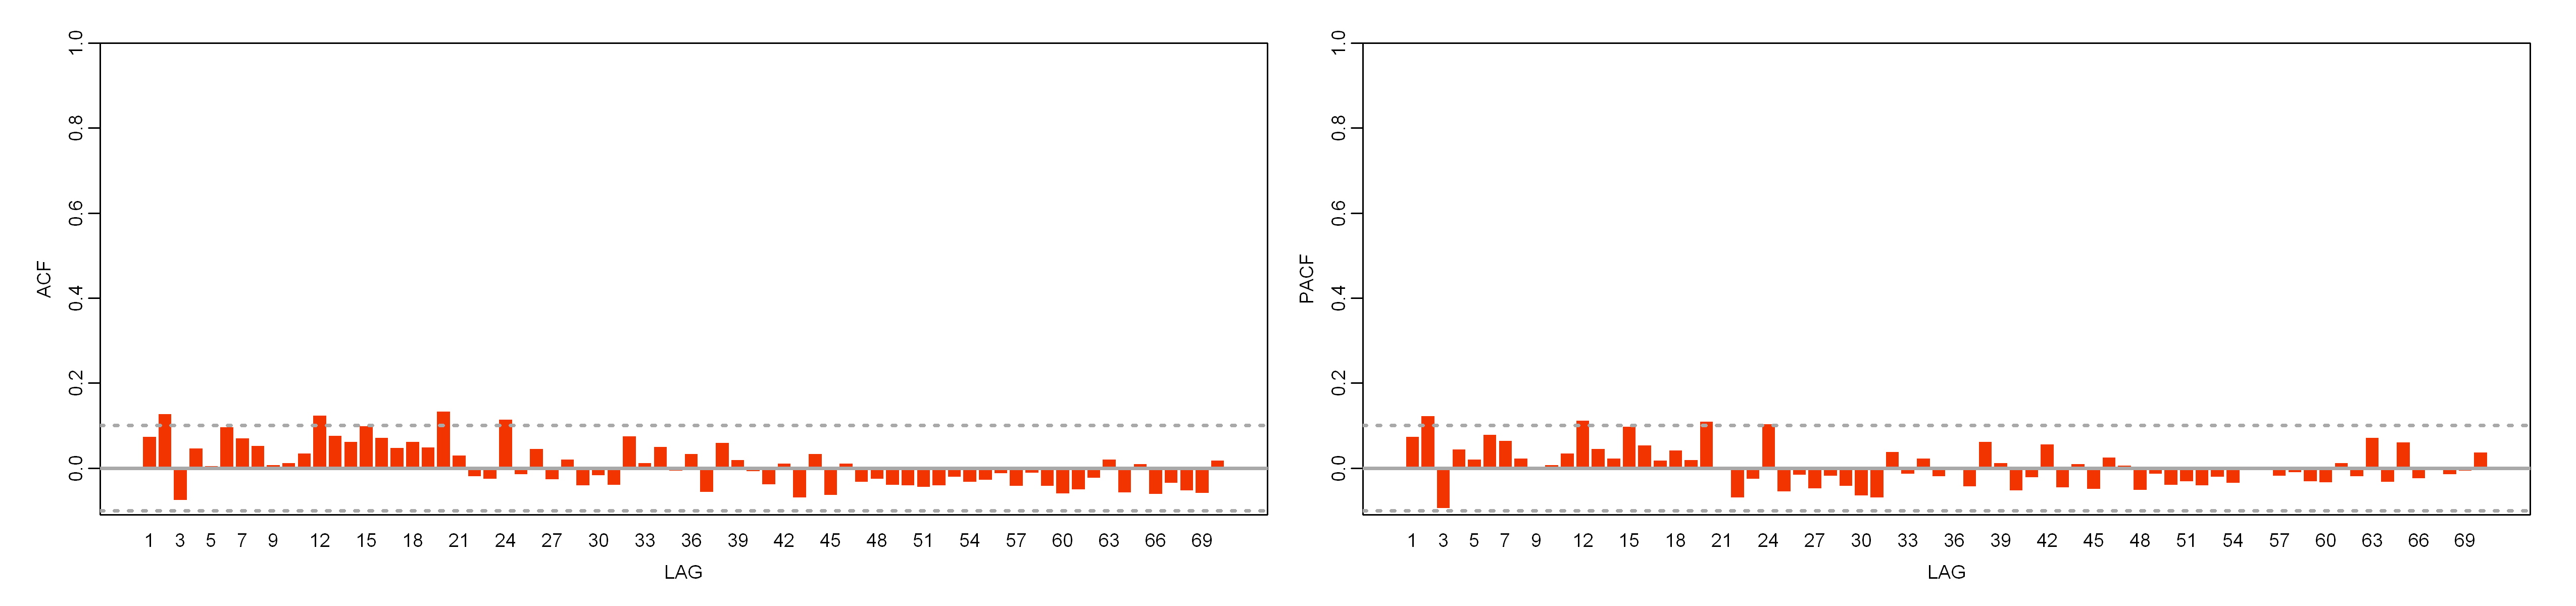

In [74]:
fig(17, 4, 300)
ac(logretdiff_arima$residuals ^ 2, max.lag=70)

Видим, что некоторые коэффициенты "пробивают" границу 95%-го доверительного интервала, то есть выполняется условие:  
$∃cov(e_t^2,e_{t-τ}^2) ≠ 0$ для некоторых τ ≥ 1.

Автокорреляционные функции не демонстрируют сходства с теоретическими для моделей ARIMA, однако по ряду остатков видно, что, скорее всего, для моделирования волатильности в данном случае подойдет модель GARCH(1, 1).  
Построим модели ARCH(1) и GARCH(1, 1) по ряду остатков модели ARIMA и сравним их характеристики.

In [75]:
library(fGarch)

Загрузка требуемого пакета: timeDate

Загрузка требуемого пакета: timeSeries


Присоединяю пакет: 'timeSeries'


Следующий объект скрыт от 'package:psych':

    outlier


Загрузка требуемого пакета: fBasics


Присоединяю пакет: 'fBasics'


Следующий объект скрыт от 'package:psych':

    tr




Строим модель ARCH(1):

In [76]:
logretdiff_arch <- garchFit(~garch(1, 0), logretdiff_arima$residuals, trace=FALSE, include.mean=FALSE)
summary(logretdiff_arch)

Warning message:
"Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead."



Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~garch(1, 0), data = logretdiff_arima$residuals, 
    include.mean = FALSE, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(1, 0)
<environment: 0x000000002e3af6d8>
 [data = logretdiff_arima$residuals]

Conditional Distribution:
 norm 

Coefficient(s):
    omega     alpha1  
0.0023424  0.0644318  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
omega  0.0023424   0.0001992    11.76   <2e-16 ***
alpha1 0.0644318   0.0511499     1.26    0.208    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 628.2207    normalized:  1.578444 

Description:
 Mon Jun 06 23:48:06 2022 by user: goroh 


Standardised Residuals Tests:
                                Statistic p-Value     
 Jarque-Bera Test   R    Chi^2  16.01779  0.0003324913
 Shapiro-Wilk Test  R    W      0.9880157 0.002334701 
 Ljung-Box Test     R    Q(10)  75.54696  3.723133e-12
 Ljung-

Видим, что оценка коэффициента $α_1$ данной модели не является значимой статистически по t-критерию Стьюдента, поэтому данную модель далее рассматривать не будем.  
Переходим к построению модели GARCH(1, 1):

In [77]:
logretdiff_garch <- garchFit(~garch(1, 1), logretdiff_arima$residuals, trace=FALSE, include.mean=FALSE)
summary(logretdiff_garch)

Warning message:
"Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead."



Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~garch(1, 1), data = logretdiff_arima$residuals, 
    include.mean = FALSE, trace = FALSE) 

Mean and Variance Equation:
 data ~ garch(1, 1)
<environment: 0x000000002f7d8b00>
 [data = logretdiff_arima$residuals]

Conditional Distribution:
 norm 

Coefficient(s):
     omega      alpha1       beta1  
0.00010194  0.04433637  0.91239348  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
omega  1.019e-04   5.824e-05     1.75   0.0801 .  
alpha1 4.434e-02   1.903e-02     2.33   0.0198 *  
beta1  9.124e-01   3.394e-02    26.88   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 633.7063    normalized:  1.592227 

Description:
 Mon Jun 06 23:48:06 2022 by user: goroh 


Standardised Residuals Tests:
                                Statistic p-Value     
 Jarque-Bera Test   R    Chi^2  13.86046  0.0009777746
 Shapiro-Wilk Test  R    W      0.9895

In [78]:
print(logretdiff_garch@fit$coef)

       omega       alpha1        beta1 
0.0001019402 0.0443363679 0.9123934774 


Получили следующую модель: $σ ̂_t^2  = 0,000102 + 0,04441 \cdot ε_{t-1}^2 + 0,9123 \cdot σ_{t-1}^2$.

Все коэффициенты данной модели статистически значимы и удовлетворяют ограничениям:  
$0 < α ̂_0 < 1,    0 ≤ α ̂_1 < 1,    0 ≤ β ̂_1 < 1$.

Можем также построить модель eGARCH(1, 1):

In [79]:
library(rugarch)

Загрузка требуемого пакета: parallel


Присоединяю пакет: 'rugarch'


Следующие объекты скрыты от 'package:fBasics':

    qgh, qnig


Следующий объект скрыт от 'package:purrr':

    reduce


Следующий объект скрыт от 'package:stats':

    sigma




In [80]:
logretdiff_egarch <- ugarchfit(
    spec=ugarchspec(mean.model=list(armaOrder=c(0, 0), include.mean=TRUE),
                    variance.model=list(model='eGARCH', garchOrder=c(1, 1))), 
    data=logretdiff_arima$residuals)
logretdiff_egarch


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.005114    0.001618   -3.1598 0.001579
omega  -0.268256    0.008435  -31.8034 0.000000
alpha1 -0.239793    0.044374   -5.4039 0.000000
beta1   0.953978    0.000265 3601.8783 0.000000
gamma1  0.050843    0.021235    2.3943 0.016651

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.005114    0.001370   -3.7341 0.000188
omega  -0.268256    0.010004  -26.8142 0.000000
alpha1 -0.239793    0.045393   -5.2826 0.000000
beta1   0.953978    0.000254 3759.3272 0.000000
gamma1  0.050843    0.024661    2.0617 0.039241

LogLikelihood : 640.3168 

Information Criteria
------------------------------------
    

In [81]:
print(logretdiff_egarch@fit$coef)

         mu       omega      alpha1       beta1      gamma1 
-0.00511397 -0.26825576 -0.23979320  0.95397826  0.05084339 


Получили следующую модель: $\lnσ ̂_t^2=-0,268+0,953978\cdot \lnσ_{t-1}^2-0,239793\cdot |z_{t-1}|+0,050843\cdot z_{t-1}$.  
Все коэффициенты данной модели статистически значимы и удовлетворяют ограничениям:  
$|β ̂_1| < 1$.

Модель eGACRH(1, 1) оказалась лучше по AIC и BIC.

Построим график предсказанных по модели eGARCH(1, 1) значений условной дисперсии:

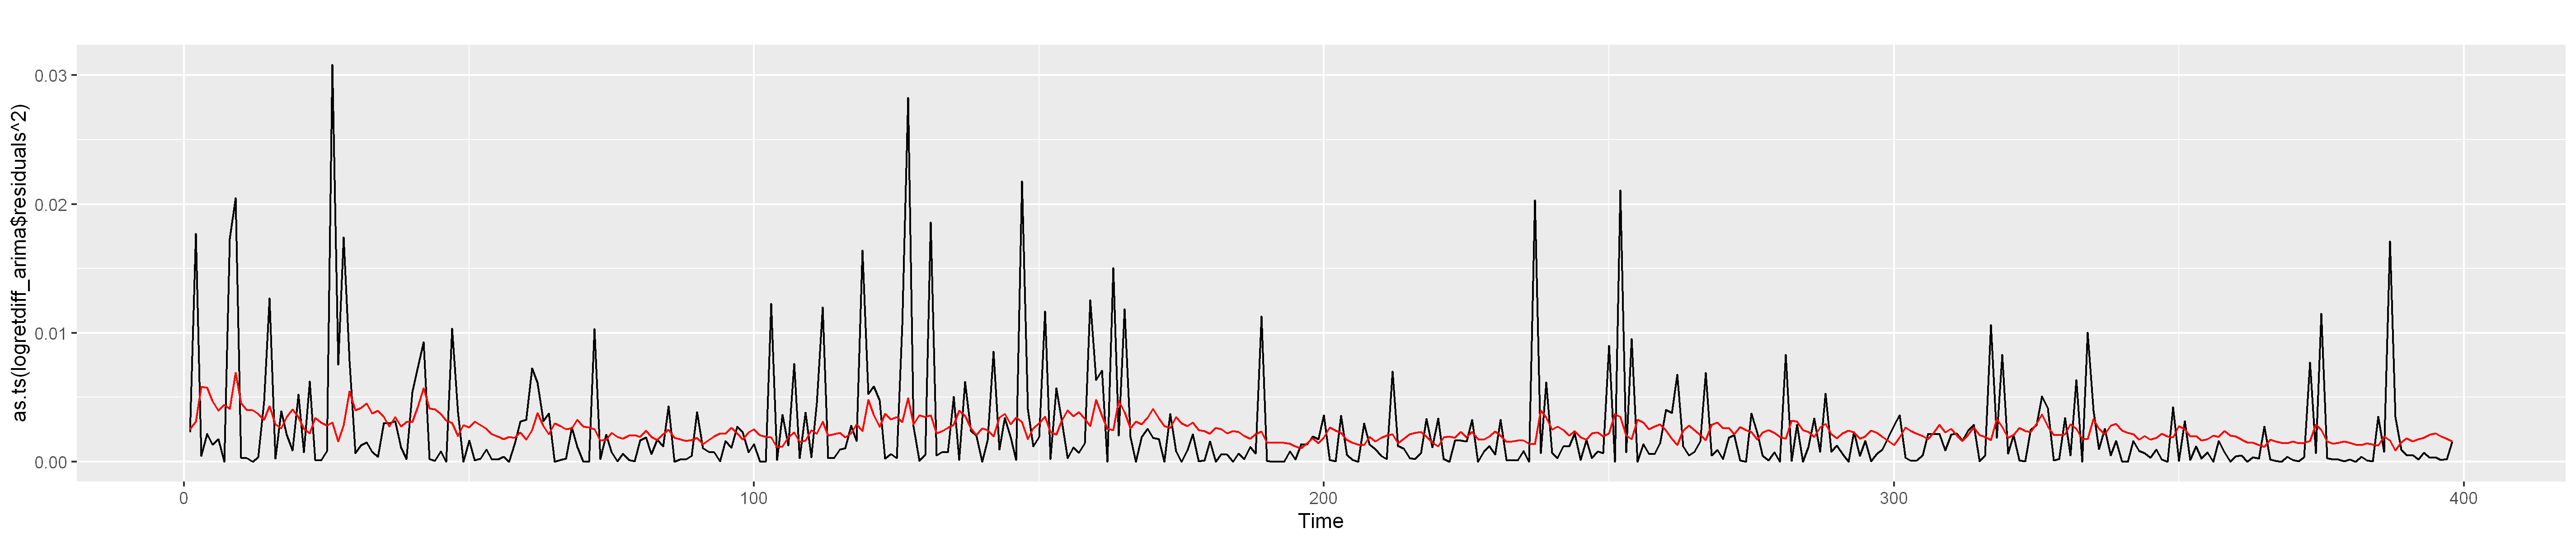

In [82]:
fig(19, 4, 300)
autoplot(as.ts(logretdiff_arima$residuals ^ 2)) +
#   geom_line(aes(y=logretdiff_garch@sigma.t ^ 2), col='red')
    geom_line(aes(y=logretdiff_egarch@fit$sigma ^ 2), col='red')

Получим ряд стандартизированных остатков и построим его график:

In [83]:
# std_resid <- logretdiff_arima$residuals / logretdiff_garch@sigma.t
std_resid <- logretdiff_arima$residuals / logretdiff_egarch@fit$sigma

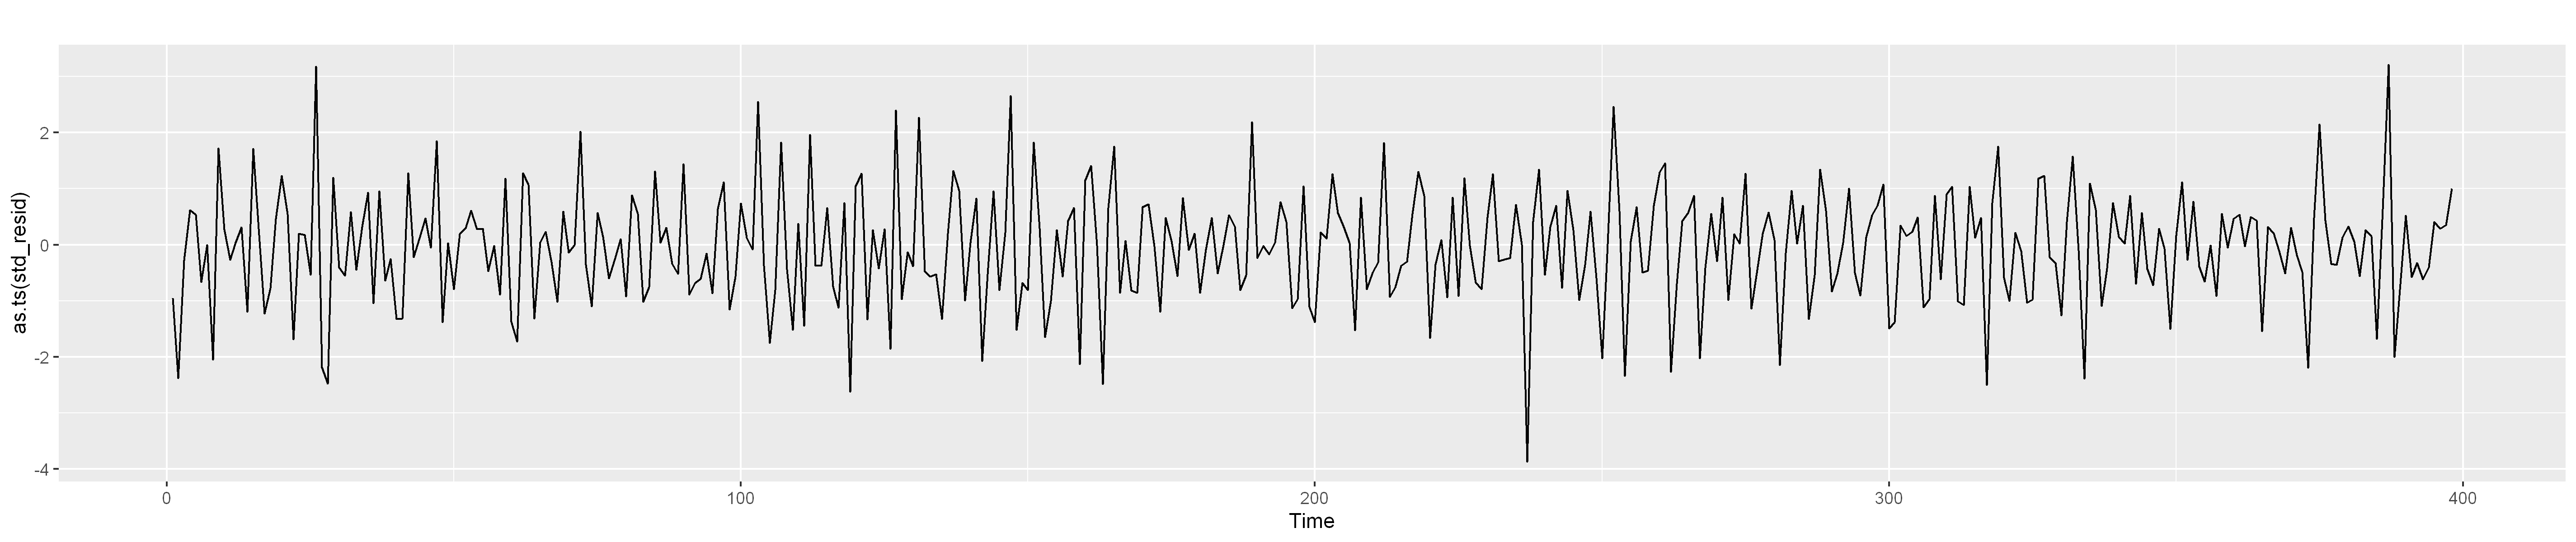

In [84]:
fig(19, 4, 300)
autoplot(as.ts(std_resid))

Проверим поведение ряда стандартизированных остатков на соответствие "белому шуму". Для этого рассмотрим график их распределения и основные статистические характеристики:

In [85]:
print(describe(std_resid))

   vars   n  mean   sd median trimmed  mad   min  max range  skew kurtosis   se
X1    1 398 -0.06 1.01      0   -0.05 0.91 -3.87 3.21  7.08 -0.05     0.63 0.05


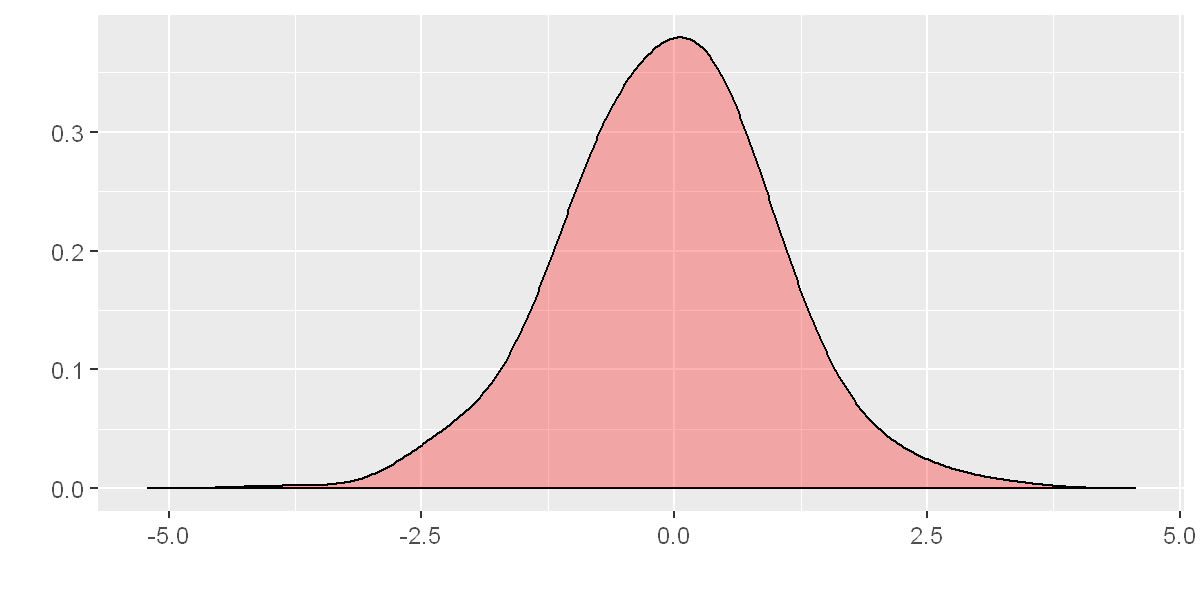

In [86]:
fig(6, 3, 200)
autoplot(density(std_resid, adjust=1.75), fill='red')

Распределение ряда стандартизированных остатков по своим характеристикам и виду близко к стандартному нормальному распределению.  
Действительно:

In [87]:
mean(std_resid)  # среднее значение ряда стандартизированных остатков

[1] -0.05751809

In [88]:
sd(std_resid)  # СКО ряда стандартизированных остатков

[1] 1.010661

Проверим следующие условия, используя параметрические тесты:

#### 1. Постоянство дисперсии ряда

##### Тест Фишера

In [89]:
var.test(std_resid[1:199], std_resid[200:398], alternative='two.sided')


	F test to compare two variances

data:  std_resid[1:199] and std_resid[200:398]
F = 1.1699, num df = 198, denom df = 198, p-value = 0.2704
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.8847558 1.5470008
sample estimates:
ratio of variances 
          1.169922 


##### Тест Бартлетта

In [90]:
bartlett.test(list(std_resid[1:199], std_resid[200:398]))


	Bartlett test of homogeneity of variances

data:  list(std_resid[1:199], std_resid[200:398])
Bartlett's K-squared = 1.2148, df = 1, p-value = 0.2704


##### Тест Кокрена

In [91]:
var1 <- var(std_resid[1:133])
var2 <- var(std_resid[134:266])
var3 <- var(std_resid[267:398])
outliers::cochran.test(object=c(var1, var2, var3), data=c(133, 133, 132))


	Cochran test for outlying variance

data:  c(var1, var2, var3)
C = 0.37302, df = 132.67, k = 3.00, p-value = 0.3585
alternative hypothesis: Group 1 has outlying variance
sample estimates:
        1         2         3 
1.1480952 1.0782444 0.8515178 


Все три теста позволяют принять нулевую гипотезу о постоянстве дисперсии ряда стандартизированных остатков.

#### 2. Постоянство и равенство нулю математического ожидания ряда

##### Тест Стьюдента

In [92]:
t.test(std_resid[1:199], std_resid[200:398], alternative='two.sided', var.equal=TRUE)


	Two Sample t-test

data:  std_resid[1:199] and std_resid[200:398]
t = -0.24992, df = 396, p-value = 0.8028
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.2247788  0.1740761
sample estimates:
  mean of x   mean of y 
-0.07019376 -0.04484242 


##### Тест Фишера

In [93]:
var1 <- var(std_resid[1:133])
var2 <- var(std_resid[134:266])
var3 <- var(std_resid[267:398])
var_mean <- var(std_resid)  # средняя дисперсия ряда
mean1 <- mean(std_resid[1:133])
mean2 <- mean(std_resid[134:266])
mean3 <- mean(std_resid[267:398])
F.stat <- sum(((c(mean1, mean2, mean3) - mean(std_resid)) ^ 2) * c(133, 133, 132)) / ((3 - 1) * var_mean)
F.crit <- qf(0.975, 3 - 1, 398 - 3)
print(F.stat)
print(F.crit)

[1] 0.0412938
[1] 3.723545


На основании результатов обоих тестов принимаем гипотезу о постоянстве математического ожидания ряда.

#### 3. Отсутствие автокорреляции уровней ряда

Построим коррелограммы ВАФ и ЧАФ для ряда абсолютных значений стандартизированных остатков:

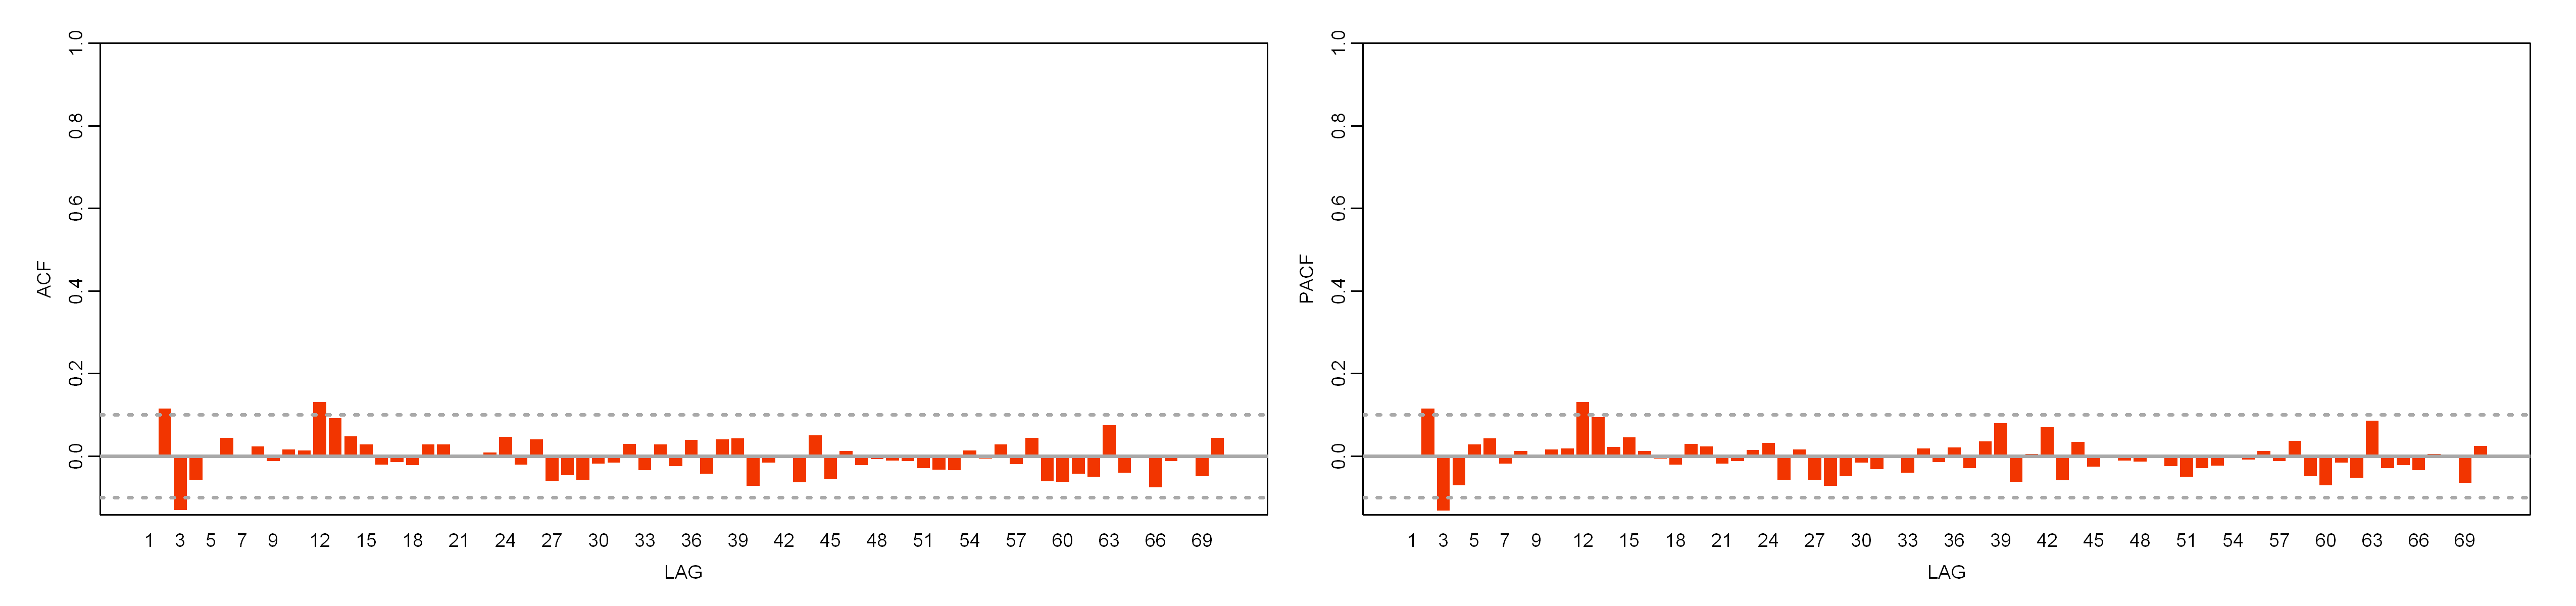

In [94]:
fig(17, 4, 300)
ac(abs(std_resid), max.lag=70)

При некоторых лагах наблюдается небольшое отклонение по сравнению с «белым шумом», поскольку ожидаем, что 5% коэффициентов для всех возможных лагов выйдет за пределы границ доверительного интервала при верной нулевой гипотезе: $ρ_τ = 0$. На коррелограмме нет существенных доказательств присутствия в ряду стандартизированных остатков ARCH-эффектов.  
Для того, чтобы убедиться в этом, используем тесты Льюнга-Бокса и Бокса-Пирса:

##### Тест Льюнга-Бокса

In [95]:
Box.test(abs(std_resid), lag=10, type='Ljung')


	Box-Ljung test

data:  abs(std_resid)
X-squared = 14.687, df = 10, p-value = 0.1439


##### Тест Бокса-Пирса

In [96]:
Box.test(abs(std_resid), lag=10, type='Box-Pierce')


	Box-Pierce test

data:  abs(std_resid)
X-squared = 14.502, df = 10, p-value = 0.1513


Результаты тестов позволяют принять нулевую гипотезу об отсутствии автокорреляции и говорят о том, что спецификация модели достаточно хорошо улавливает эффекты ARCH.

## Разынтеграция модели и построение прогноза

Разынтегрированная модель AR(1) по ряду 1-ых разностей лог-доходности будет выглядеть следующим образом:  
$y ̂_t = e^{α ̂_0} \cdot y^{α ̂_1 + 2}_{t-1} \cdot y^{-(2α ̂_1+1)}_{t-2} \cdot y^{α ̂_1}_{t-3}$.

In [97]:
arima_fitted <- c(rep(NA, 3), numeric(397))

# разынтеграция модели по формуле
for (t in 4:400) {
    arima_fitted[t] <- exp(a_0 + (a_1 + 2) * log(BTC_daily$CBBTCUSD[t - 1]) -
                           (2 * a_1 + 1) * log(BTC_daily$CBBTCUSD[t - 2]) + a_1 * log(BTC_daily$CBBTCUSD[t - 3]))
}

Построим график исходного ряда и подобранной модели ARIMA(1, 1, 0) по ряду лог-доходности:

Warning message:
"Removed 3 row(s) containing missing values (geom_path)."


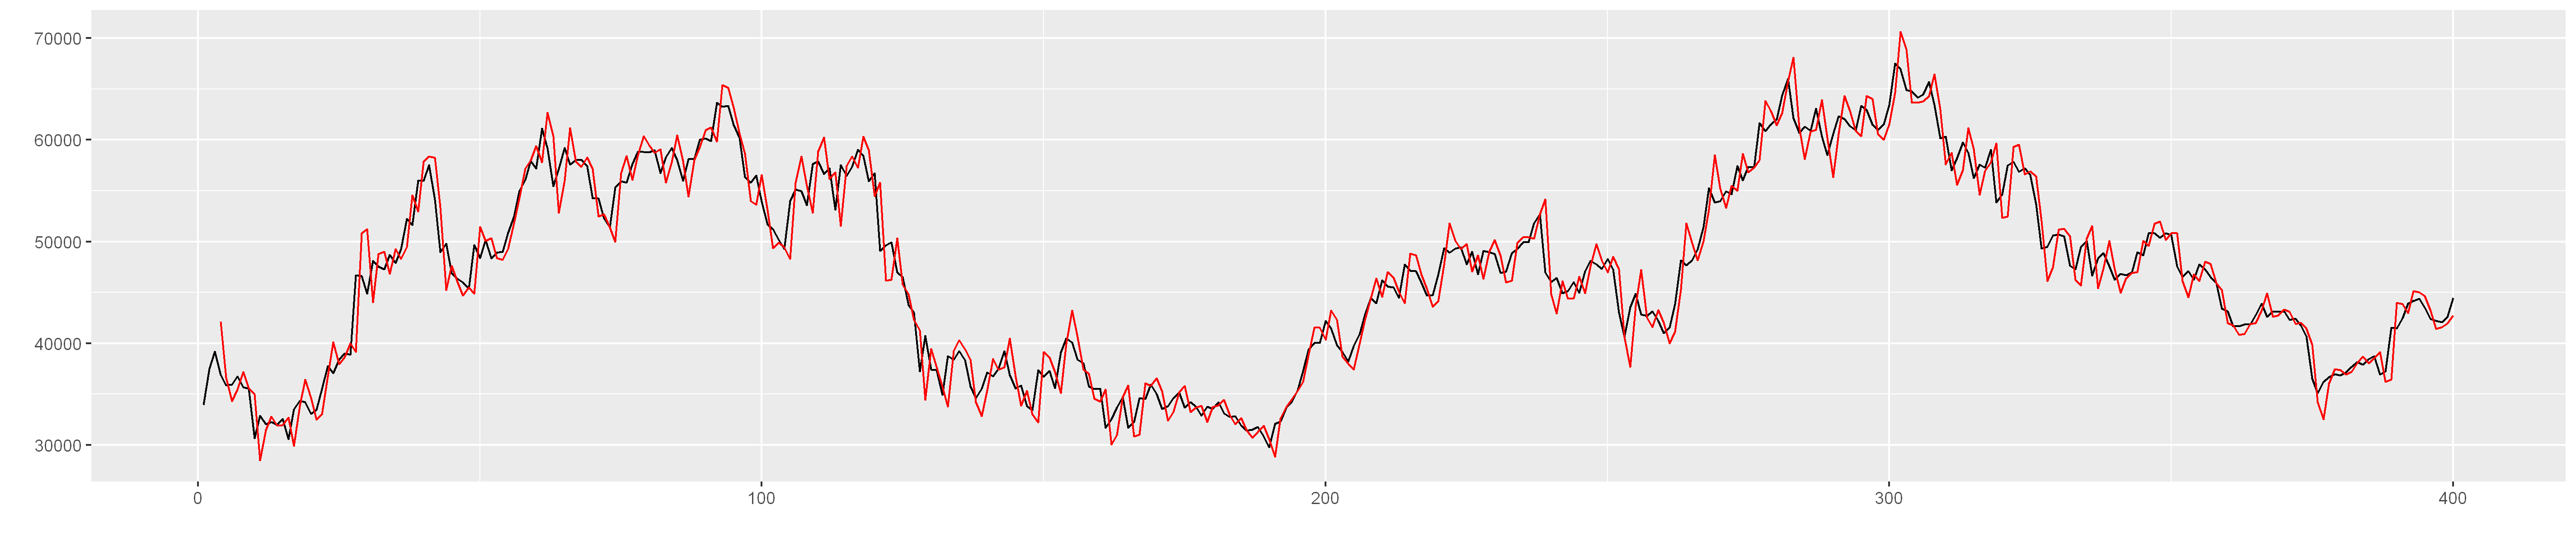

In [98]:
fig(19, 4, 300)
daily.plot +
    geom_line(aes(y=arima_fitted), col='red')

Спрогнозируем курс Биткоина на 2 дня вперед по следующим формулам:  
$y ̂_{t+1}=y_t^{α ̂_1+2}y_{t-1}^{-(2α ̂_1+1)}y_{t-2}^{α ̂_1}e^{-α ̂_1μ+μ}$,  
$y ̂_{t+2}=y_{t+1}^2y_t^{α ̂_1^2-1}y_{t-1}^{-2α ̂_1^2}y_{t-2}^{α ̂_1^2}e^{-α ̂_1^2μ+μ}$,  
где $μ=M[∆z_t]$ – математическое ожидание ряда первых разностей ряда логарифмической доходности.

In [99]:
y <- BTC_daily$CBBTCUSD

In [100]:
mu <- a_0 / (1 - a_1) 
mu

[1] -7.859523e-05

Точечный прогноз на период (t + 1):

In [101]:
y_1 <- y[400]^(a_1 + 2) * y[399]^(-(1 + 2 * a_1)) * y[398]^a_1 * exp(-a_1 * mu + mu)
y_1  # прогнозное значение на период (t + 1)

[1] 45664.15

Точечный прогноз на период (t + 2):

In [102]:
y_2 <- y_1^2 * y[400]^(a_1^2 - 1) * y[399]^(-2 * a_1^2) * y[398]^(a_1^2) * exp(- a_1^2 * mu + mu)
y_2  # прогнозное значение на период (t + 2)

[1] 47307.14

Интервальный прогноз осуществим по модели eGARCH(1, 1).    
Далее произведем разынтеграцию зачений границ интервала по формулам:  
$y_{t+1} = y_t^2 \cdot \frac{1} {y_{t-1}} \cdot e^{α ̂_0 + α ̂_1 \cdot ∆z ̂_t}$,  
$y_{t+2} = y_t^3 \cdot \frac{1} {y_{t-1}^2} \cdot e^{α ̂_0 \cdot (1 + α ̂_1) + ∆z ̂_t \cdot (α ̂_1 + α ̂_1^2)}$.

In [103]:
u_a <- qnorm(1 - 0.05 / 2, mean=0, sd=1)
u_a  # квантиль стандартного нормального распределения для уровня значимости 0,05

[1] 1.959964

In [104]:
# msfe_1 <- fGarch::predict(logretdiff_garch, n.ahead=1, mse='cond', plot=FALSE)$standardDeviation[1]
msfe_1 <- ugarchforecast(logretdiff_egarch)@forecast$sigmaFor[1]
print(msfe_1)  # ошибка прогноза на период (t + 1)

[1] 0.03569618


In [105]:
# msfe_2 <- fGarch::predict(logretdiff_garch, n.ahead=2, mse='cond', plot=FALSE)$standardDeviation[2]
msfe_1 <- ugarchforecast(logretdiff_egarch)@forecast$sigmaFor[2]
print(msfe_2)  # ошибка прогноза на период (t + 2)

[1] 0.04352536


Интервальный прогноз на период (t + 1) без разынтеграции:

In [106]:
y_11 <- forecast::forecast(logretdiff_arima, 2, 0.95)$mean[1]
lower_11 <- y_11 - msfe_1 * u_a
upper_11 <- y_11 + msfe_1 * u_a
paste(lower_11, '  ', upper_11)

[1] "-0.0884799648437778    0.0541660762798856"

Интервальный прогноз на период (t + 1) после разынтеграции:

In [107]:
lower_1 <- y[400]^2 / y[399] * exp(a_0 + a_1 * lower_11)
upper_1 <- y[400]^2 / y[399] * exp(a_0 + a_1 * upper_11)

# меняем значения переменных местами, так как после разынтеграции границы отобразились зеркально (проверка мат. вычислениями)
f <- lower_1
lower_1 <- upper_1
upper_1 <- f

paste(lower_1, y_1, upper_1)

[1] "45145.3250325188 45664.1453884724 48651.4024863893"

Интервальный прогноз на период (t + 2) без разынтеграции:

In [108]:
y_22 <- forecast::forecast(logretdiff_arima, 2, 0.95)$mean[2]
lower_22 <- y_22 - msfe_2 * u_a
upper_22 <- y_22 + msfe_2 * u_a
paste(lower_22, '  ', upper_22)

[1] "-0.0764948210157991    0.0941214499048115"

Интервальный прогноз на период (t + 2) после разынтеграции:

In [109]:
lower_2 <- y[400]^3 / y[399]^2 * exp(a_0 * (3 + a_1) + lower_22 * (2 * a_1 + a_1^2))
upper_2 <- y[400]^3 / y[399]^2 * exp(a_0 * (3 + a_1) + upper_22 * (2 * a_1 + a_1^2))

f <- lower_2
lower_2 <- upper_2
upper_2 <- f

paste(lower_2, y_2, upper_2)

[1] "45100.0895963394 47307.1436272635 51464.7384233161"

Отобразим полученный прогноз на графике и сравним с фактическими значениями:

In [110]:
BTC_valid <- read.csv('./data/CBBTCUSD_valid.csv')  # загрузка валидационного датасета
BTC_valid <- BTC_valid[1828:1829, ]
BTC_valid['CBBTCUSD'] <- sapply(BTC_valid['CBBTCUSD'], as.numeric)
BTC_valid$DATE <- as.Date(BTC_valid$DATE, format='%Y-%m-%d')
print(BTC_valid)

           DATE CBBTCUSD
1828 2022-02-16 43897.22
1829 2022-02-17 40553.82


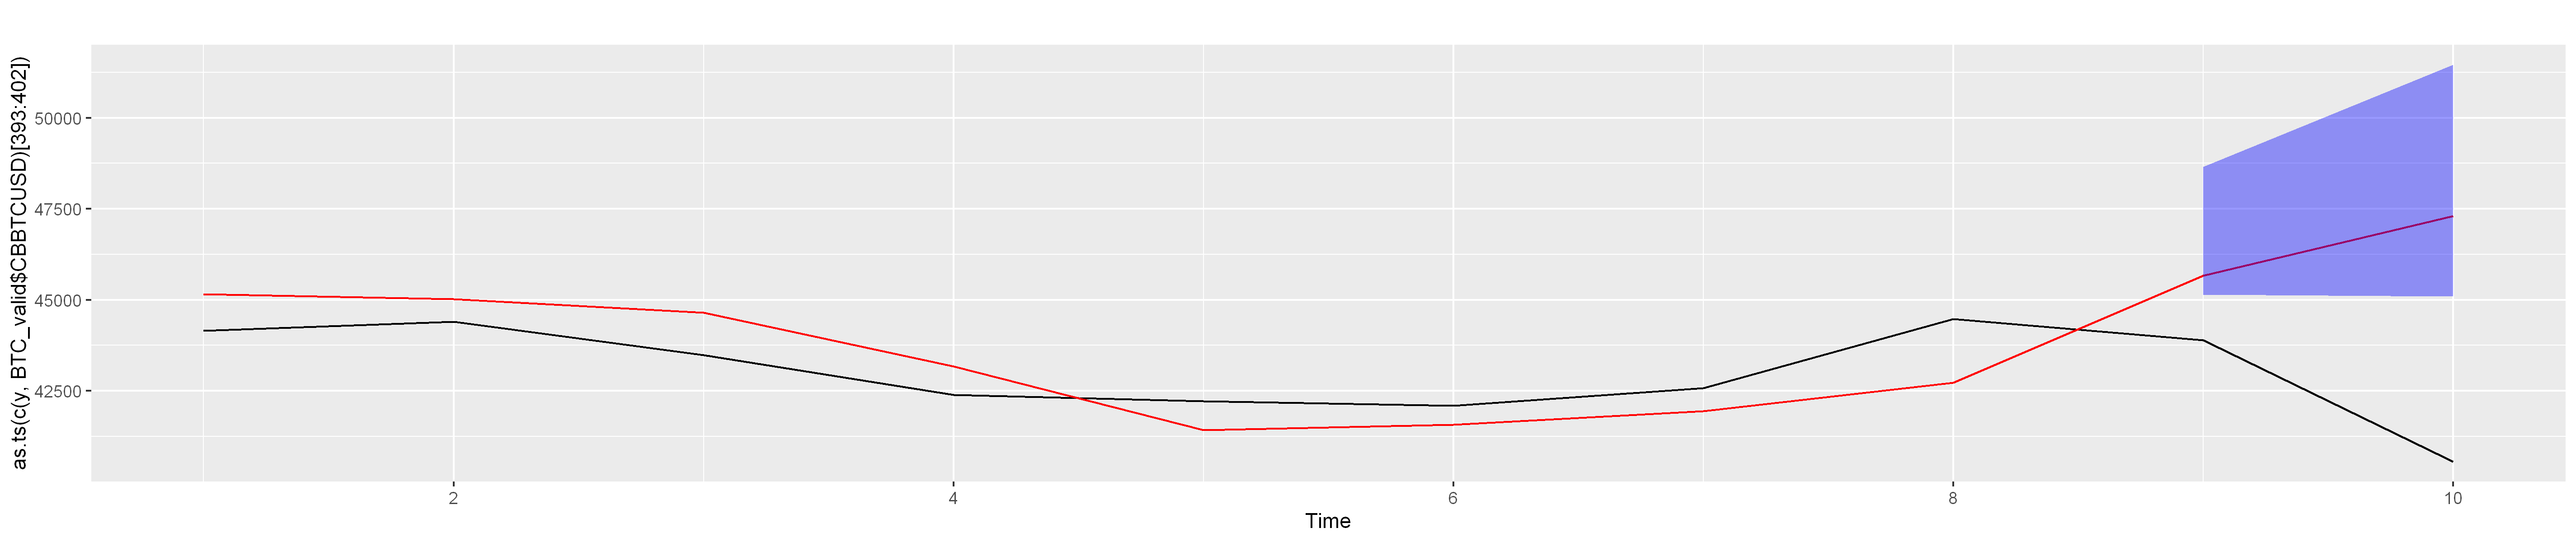

In [111]:
fig(19, 4, 300)
autoplot(as.ts(c(y, BTC_valid$CBBTCUSD)[393:402])) +
    geom_line(aes(y=c(arima_fitted[393:400], y_1, y_2)), col='red') +
    geom_ribbon(aes(ymin=c(rep(NA, 8), lower_1, lower_2), ymax=c(rep(NA, 8), upper_1, upper_2)), fill='blue', alpha=.4)

In [112]:
save.image('./case_BTC.RData')